In [255]:
#pip install pytrends
#!pip install tensorflow
#pip install pm

In [256]:
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.signal import savgol_filter
from scipy.stats import boxcox

# Time series analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Machine learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_regression

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, LayerNormalization, GlobalAveragePooling1D, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# Utilities
import os
import time
import random
from typing import Dict, List, Tuple, Optional



# Load Data

In [257]:
data = pd.read_csv('selected_google_trends_value.csv')

#preprocesseed data
df=pd.read_excel('E-Commerce Transactions Value.xlsx')

In [258]:
data.head()

date  Avon  Property24  We Buy Cars  Game  Telkom  computer  \
0  2018-12-30    34          23            7    11      61        13   
1  2018-12-31    29          22            5    13      72        11   
2  2019-01-01    39          30            9    13      58        12   
3  2019-01-02    42          31           11    13      81        14   
4  2019-01-03    45          34           13    12      71        17   

   Cars for Sale  AutoTrader  MTN  clothing  Betfred  Puma  
0             25          17   29        63        0    19  
1             20          15   32        53        0    16  
2             27          20   29        50        0    12  
3             30          22   42        58        0     9  
4             27          23   35        53        0    10

In [259]:
df.head()

Date  E-Commerce Transactions: Value
0 2018-12-30                    48229.459312
1 2018-12-31                    68629.143788
2 2019-01-01                    52162.890120
3 2019-01-02                    66311.844346
4 2019-01-03                    95740.128026

In [260]:
df.rename(columns={'E-Commerce Transactions: Value': 'Value'}, inplace=True)

# Verify
df.head()

Date         Value
0 2018-12-30  48229.459312
1 2018-12-31  68629.143788
2 2019-01-01  52162.890120
3 2019-01-02  66311.844346
4 2019-01-03  95740.128026

# Value

In [261]:
# Rename column in df_trends (or any other DataFrame)
df.rename(columns={'Date': 'date'}, inplace=True)


In [262]:
data.shape

(2365, 13)

In [263]:
df.shape

(2365, 2)

In [264]:
df.isna().sum().sum()

0

In [265]:
describe = df.describe()
describe.style.background_gradient(cmap='Greens')

In [266]:
df.isna().sum().sum()

0

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2365 non-null   datetime64[ns]
 1   Value   2365 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.1 KB


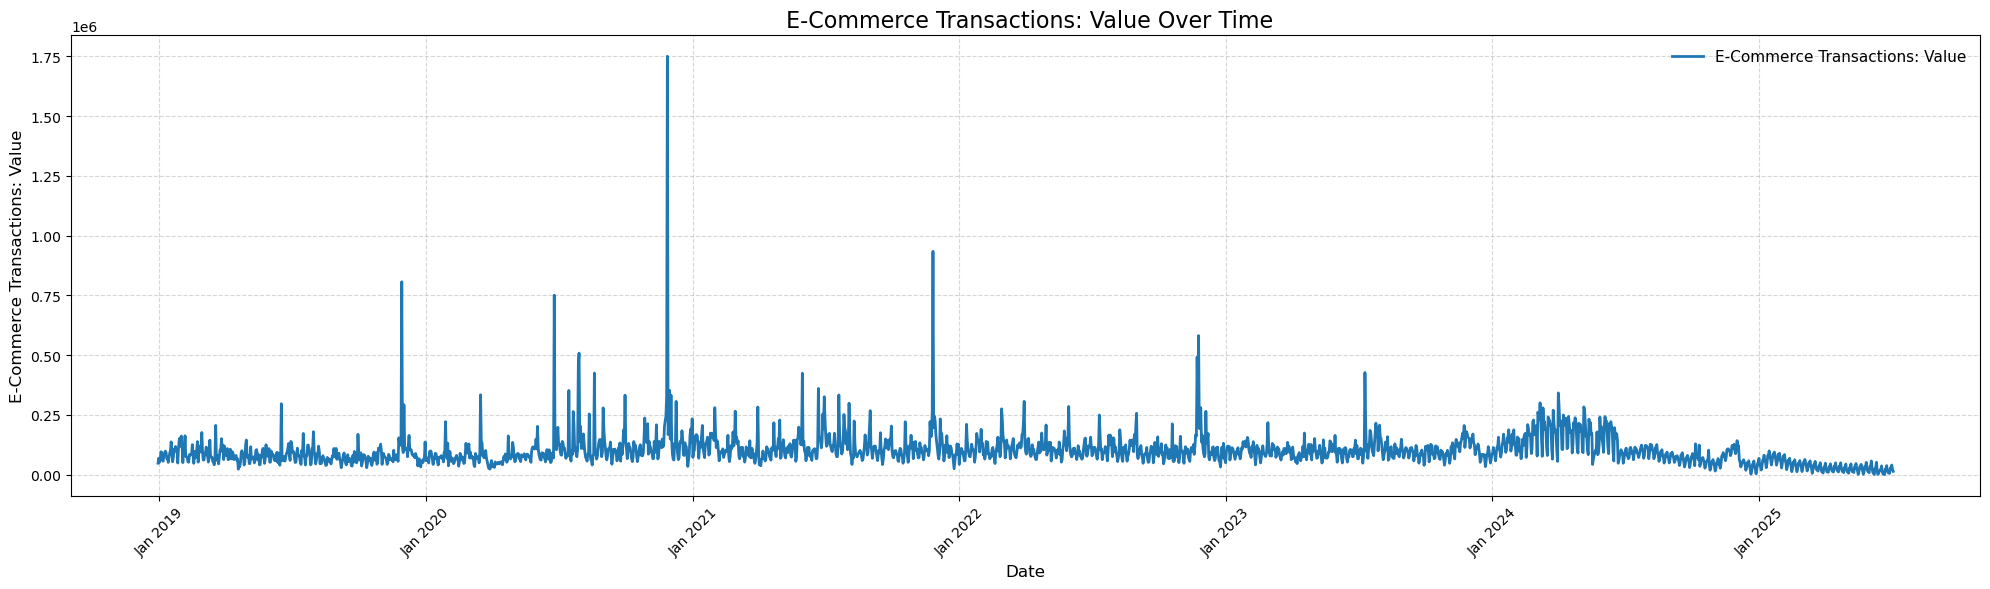

In [268]:
# Plot 
plt.figure(figsize=(20, 6))

plt.plot(df['date'], df['Value'], linewidth=2, label='E-Commerce Transactions: Value')

# Format x-axis 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) 
plt.xticks(rotation=45)
# Styling
plt.title(" E-Commerce Transactions: Value Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("E-Commerce Transactions: Value", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=False, fontsize=11)
plt.tight_layout()
plt.show()

In [269]:
#Convert Date to datetime, set date as index
df['date'] = pd.to_datetime(df['date'], errors='coerce')  
df = df.sort_values('date')  
df = df.set_index('date')

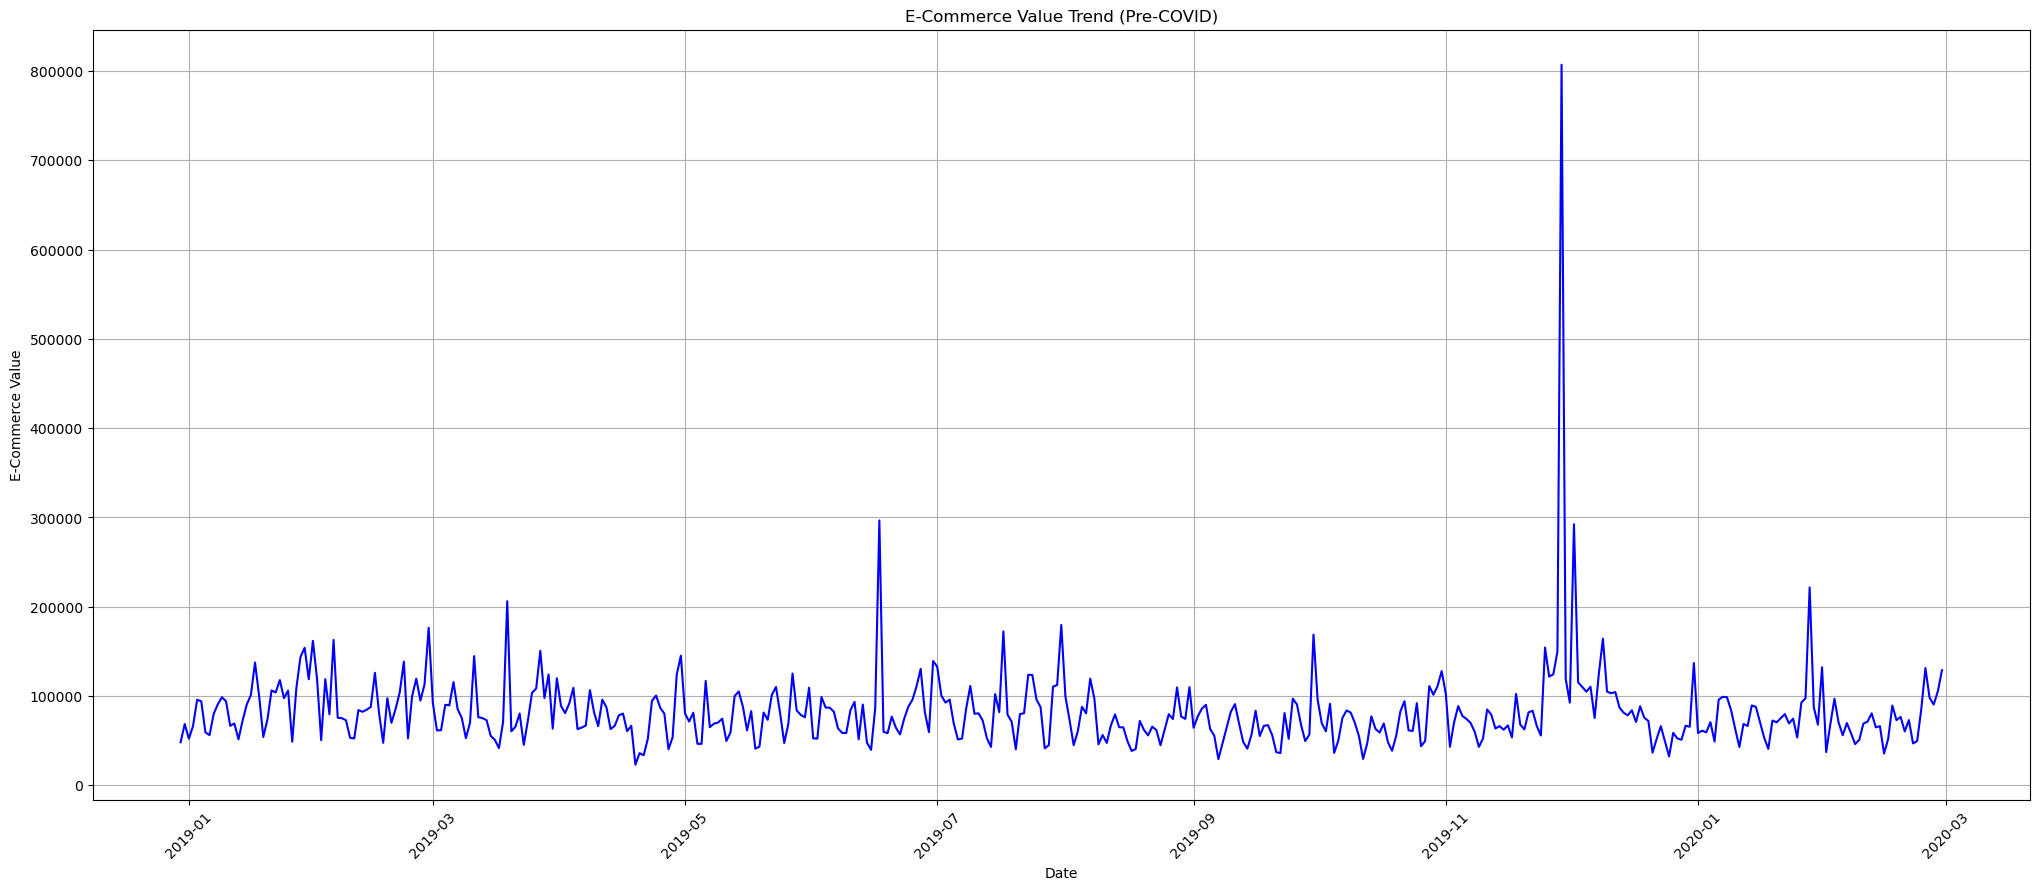

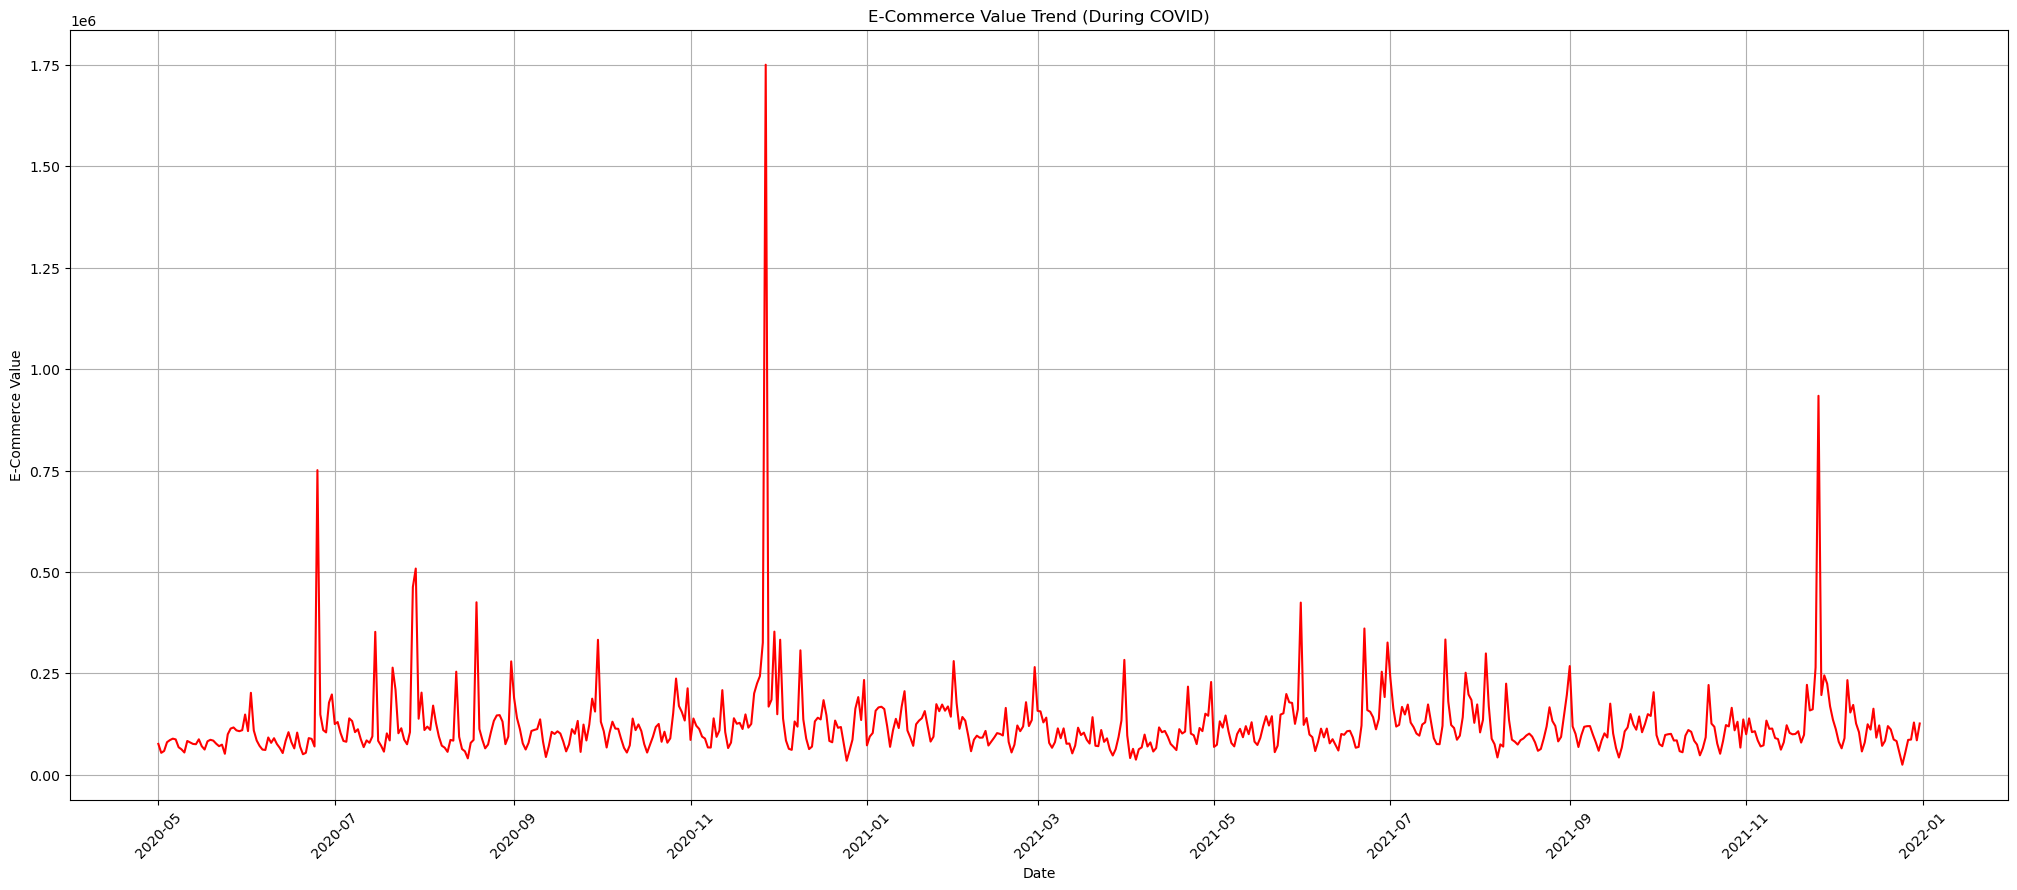

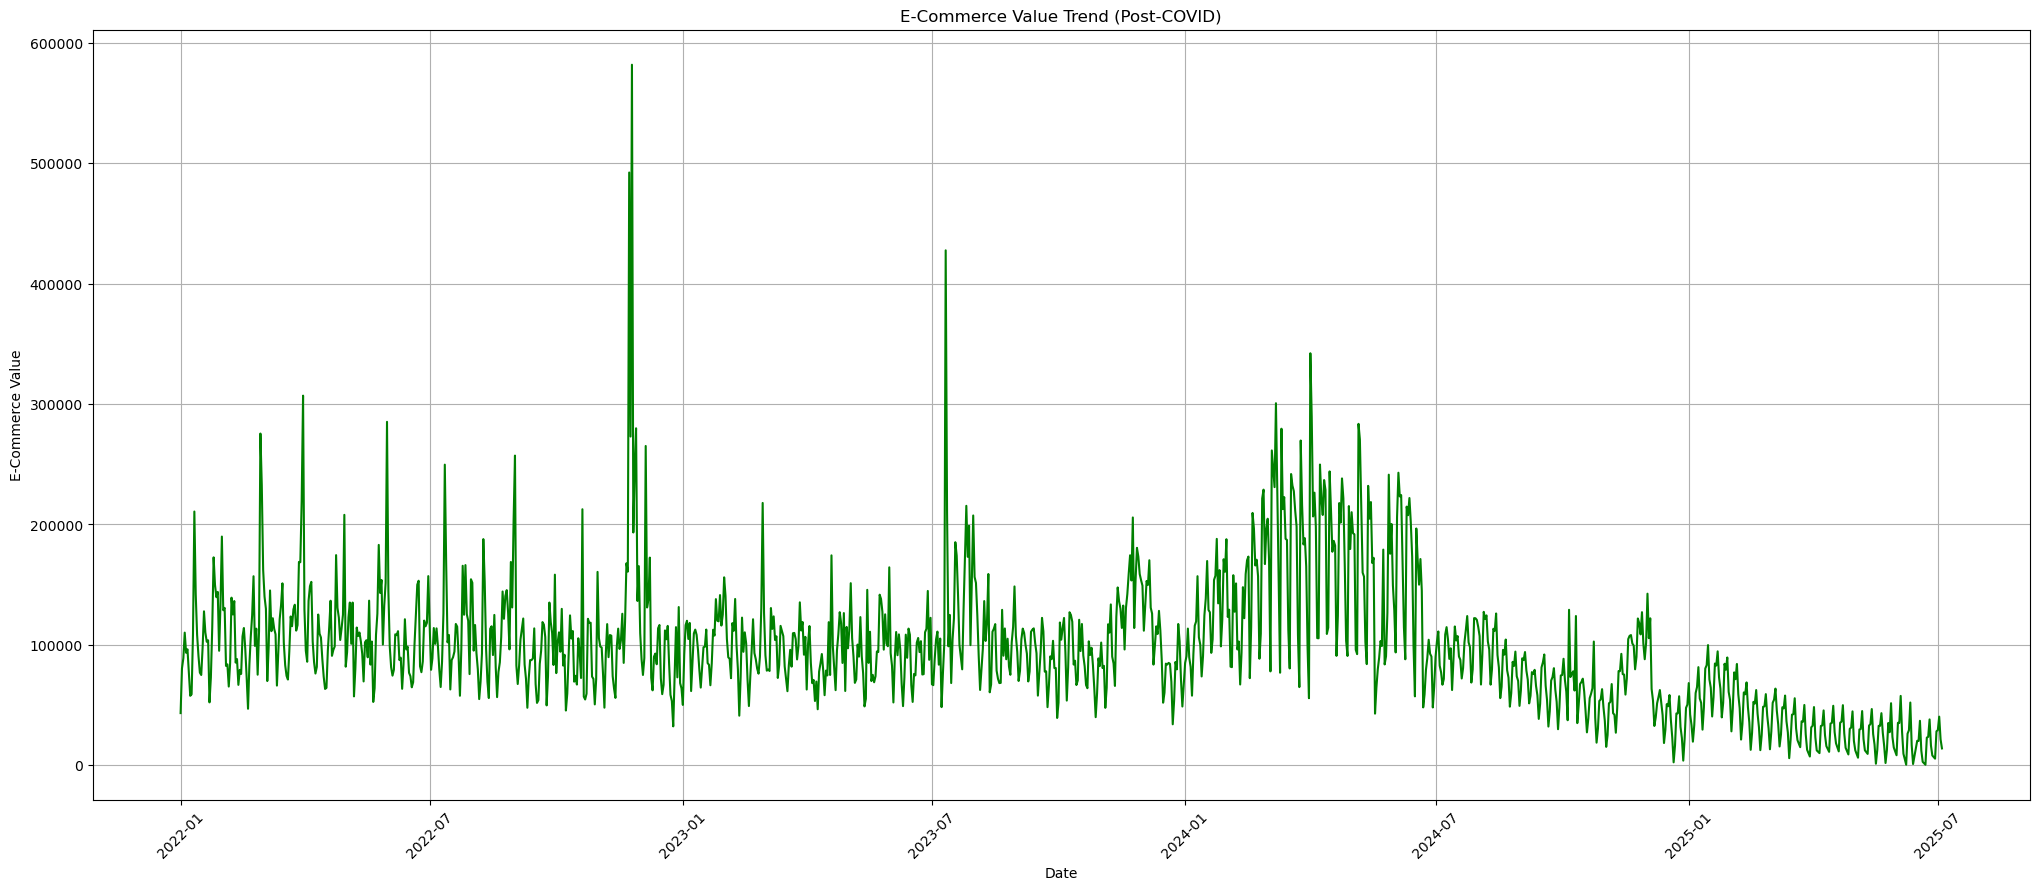

In [270]:
# Define periods
pre_covid_end = '2020-02-29'
covid_start = '2020-05-01'
covid_end = '2021-12-31'
post_covid_start = '2022-01-01'

# Split data using df
data_pre_covid = df[df.index <= pre_covid_end]
data_covid = df[(df.index >= covid_start) & (df.index <= covid_end)]
data_post_covid = df[df.index >= post_covid_start]

# Plot 1: Pre-COVID
plt.figure(figsize=(25,10))
plt.plot(data_pre_covid.index, data_pre_covid['Value'], color='blue')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (Pre-COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot 2: During COVID
plt.figure(figsize=(25,10))
plt.plot(data_covid.index, data_covid['Value'], color='red')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (During COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot 3: Post-COVID
plt.figure(figsize=(25,10))
plt.plot(data_post_covid.index, data_post_covid['Value'], color='green')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (Post-COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Text(0, 0.5, 'Frequency')

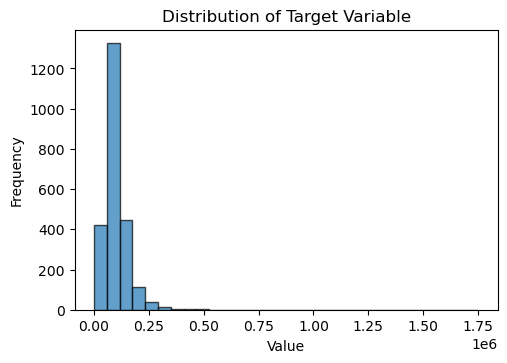

In [271]:
plt.figure(figsize=(12, 8))

#  Distribution of target variable
plt.subplot(2, 2, 2)
plt.hist(df['Value'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')


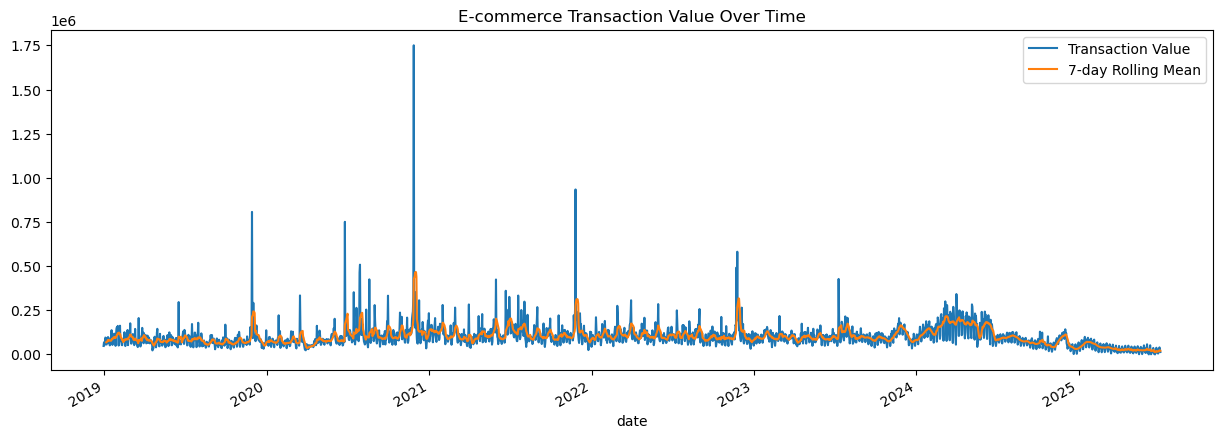

In [272]:
# Plot time series with rolling mean
df['Value'].plot(figsize=(15,5), label='Transaction Value')
df['Value'].rolling(window=7).mean().plot(label='7-day Rolling Mean')
plt.legend()
plt.title('E-commerce Transaction Value Over Time')
plt.show()

In [273]:
result = adfuller(df['Value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] <= 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")

ADF Statistic: -4.351200120168895
p-value: 0.00036176400763231686
   1%: -3.4331512397333626
   5%: -2.8627775348975866
   10%: -2.567428794167024
The time series is stationary


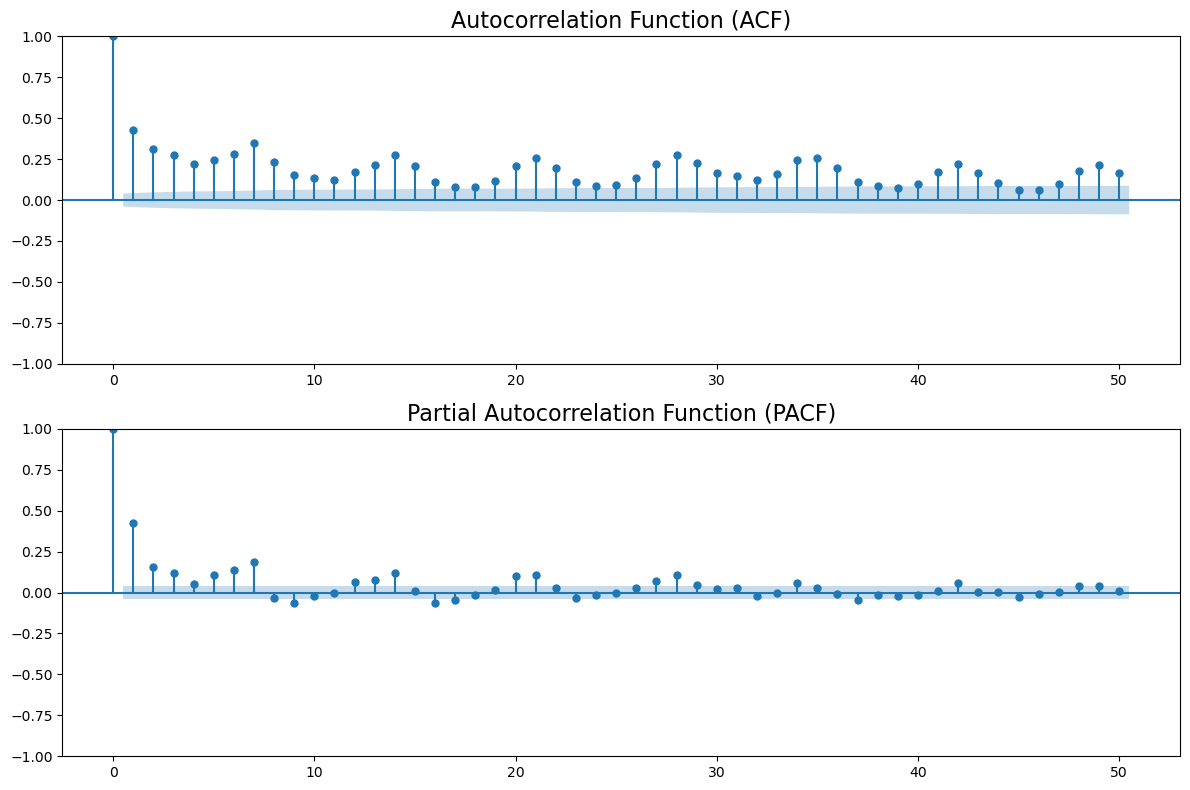

In [274]:
plt.figure(figsize=(12, 8))

# ACF plot
plt.subplot(2, 1, 1)
plot_acf(df['Value'], lags=50, ax=plt.gca(), alpha=0.05)  # alpha=0.05 for 95% CI
plt.title('Autocorrelation Function (ACF)', fontsize=16)

# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(df['Value'], lags=50, ax=plt.gca(), alpha=0.05, method='ywm')  # method='ywm' avoids warnings
plt.title('Partial Autocorrelation Function (PACF)', fontsize=16)

plt.tight_layout()
plt.show()

In [275]:
df.head()

Value
date                    
2018-12-30  48229.459312
2018-12-31  68629.143788
2019-01-01  52162.890120
2019-01-02  66311.844346
2019-01-03  95740.128026

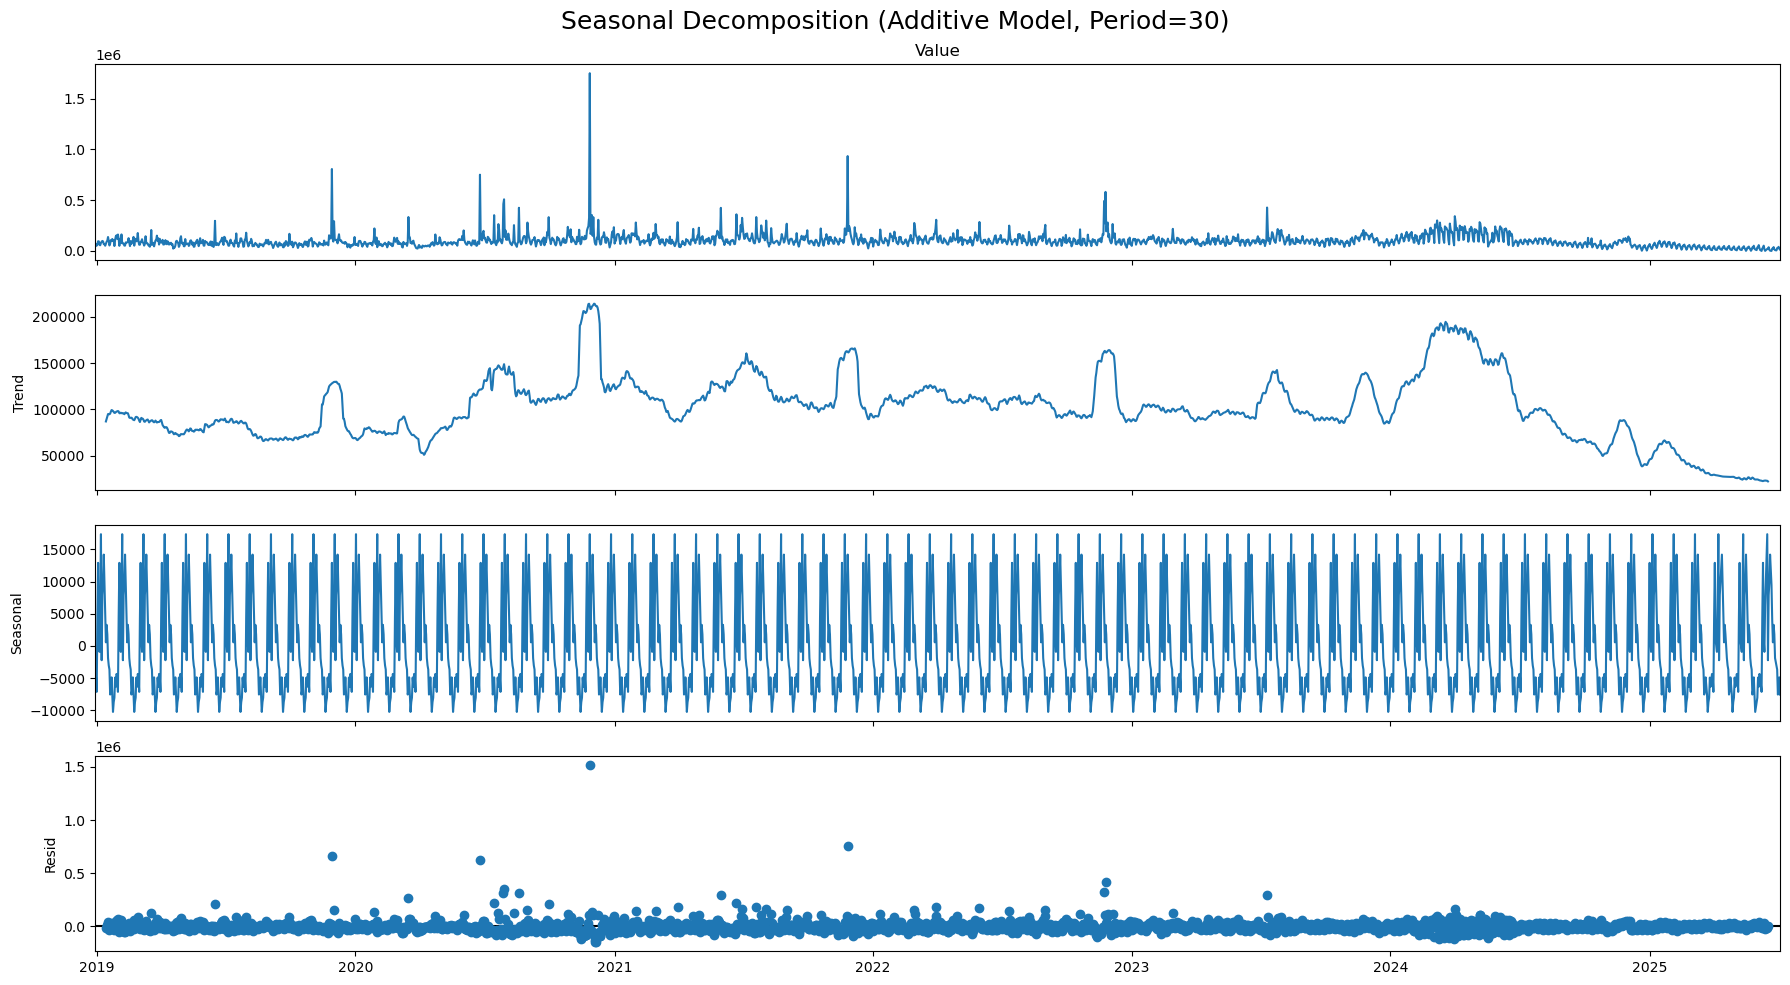

In [276]:
# Seasonal Decomposition for original data
decomp = seasonal_decompose(df['Value'], model='additive', period=30)

# Plot decomposition
fig = decomp.plot()
fig.set_size_inches(18, 10)   # set size directly on figure
fig.suptitle("Seasonal Decomposition (Additive Model, Period=30)", fontsize=18)

plt.tight_layout()
plt.show()

In [277]:
# Drop NaNs from trend to align all components
T = decomp.trend.dropna().values
S = decomp.seasonal[decomp.trend.notna()].values
R = decomp.resid[decomp.trend.notna()].values

# Compute Trend Strength
var_R = np.var(R)
var_T_plus_R = np.var(T + R)
F_T = max(0, 1 - var_R / var_T_plus_R)

# Compute Seasonality Strength
var_S_plus_R = np.var(S + R)
F_S = max(0, 1 - var_R / var_S_plus_R)

print(f"Trend Strength : {F_T:.4f}")
print(f"Seasonality Strength : {F_S:.4f}")

Trend Strength : 0.2833
Seasonality Strength : 0.0158


In [278]:
df.head()

Value
date                    
2018-12-30  48229.459312
2018-12-31  68629.143788
2019-01-01  52162.890120
2019-01-02  66311.844346
2019-01-03  95740.128026

 # Google Trends

In [279]:
data.head()

date  Avon  Property24  We Buy Cars  Game  Telkom  computer  \
0  2018-12-30    34          23            7    11      61        13   
1  2018-12-31    29          22            5    13      72        11   
2  2019-01-01    39          30            9    13      58        12   
3  2019-01-02    42          31           11    13      81        14   
4  2019-01-03    45          34           13    12      71        17   

   Cars for Sale  AutoTrader  MTN  clothing  Betfred  Puma  
0             25          17   29        63        0    19  
1             20          15   32        53        0    16  
2             27          20   29        50        0    12  
3             30          22   42        58        0     9  
4             27          23   35        53        0    10

In [280]:
data.shape 

(2365, 13)

In [281]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           2365 non-null   object
 1   Avon           2365 non-null   int64 
 2   Property24     2365 non-null   int64 
 3   We Buy Cars    2365 non-null   int64 
 4   Game           2365 non-null   int64 
 5   Telkom         2365 non-null   int64 
 6   computer       2365 non-null   int64 
 7   Cars for Sale  2365 non-null   int64 
 8   AutoTrader     2365 non-null   int64 
 9   MTN            2365 non-null   int64 
 10  clothing       2365 non-null   int64 
 11  Betfred        2365 non-null   int64 
 12  Puma           2365 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 240.3+ KB


In [282]:
data.columns

Index(['date', 'Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom',
       'computer', 'Cars for Sale', 'AutoTrader', 'MTN', 'clothing', 'Betfred',
       'Puma'],
      dtype='object')

In [283]:
data.describe()

Avon   Property24  We Buy Cars         Game       Telkom  \
count  2365.000000  2365.000000  2365.000000  2365.000000  2365.000000   
mean     25.906131    35.380973    34.324736    15.279915    38.791121   
std      15.633644    20.808832    12.762151     5.164334    18.039002   
min       0.000000     6.000000     5.000000     6.000000    11.000000   
25%      16.000000    17.000000    24.000000    12.000000    23.000000   
50%      22.000000    30.000000    37.000000    14.000000    34.000000   
75%      33.000000    53.000000    45.000000    18.000000    53.000000   
max     100.000000   100.000000    63.000000    65.000000   100.000000   

          computer  Cars for Sale   AutoTrader          MTN     clothing  \
count  2365.000000    2365.000000  2365.000000  2365.000000  2365.000000   
mean     16.154757      20.467230    27.659197    31.047780    50.414799   
std       6.177279       5.034681     5.241999    11.686826    17.429555   
min       2.000000      10.000000    11.000000    13.000000    16.000000   
25%      12.000000      16.000000    25.000000    21.000000    36.000000   
50%      16.000000      20.000000    28.000000    30.000000    46.000000   
75%      20.000000      24.000000    31.000000    40.000000    63.000000   
max      36.000000      36.000000    44.000000   100.000000   100.000000   

           Betfred         Puma  
count  2365.000000  2365.000000  
mean      2.264271    14.994926  
std       3.184793     5.495958  
min       0.000000     4.000000  
25%       0.000000    11.000000  
50%       0.000000    14.000000  
75%       5.000000    18.000000  
max      12.000000    36.000000

In [284]:
# set data date as index
data.set_index('date', inplace=True)

In [285]:
'''
# List of numerical Google Trends features
features = data.columns.tolist()

# Define periods
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2021-12-31'
post_covid_start = '2022-01-01'

# Split data using index
data_pre_covid = data[data.index <= pre_covid_end]
data_covid = data[(data.index >= covid_start) & (data.index <= covid_end)]
data_post_covid = data[data.index >= post_covid_start]

# Loop through features and plot
for feature in features:
    plt.figure(figsize=(20,6))
    plt.plot(data_pre_covid.index, data_pre_covid[feature], label='Pre-COVID', color='blue')
    plt.plot(data_covid.index, data_covid[feature], label='During COVID', color='red')
    plt.plot(data_post_covid.index, data_post_covid[feature], label='Post-COVID', color='green')
    
    plt.xlabel('Date')
    plt.ylabel(f'{feature} Trend Value')
    plt.title(f'{feature} Google Trend Across COVID Periods')
    plt.legend()
    
    # Show ticks every ~20 points for readability
    plt.xticks(data.index[::max(1, len(data)//20)], rotation=45)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
'''

"\n# List of numerical Google Trends features\nfeatures = data.columns.tolist()\n\n# Define periods\npre_covid_end = '2020-02-29'\ncovid_start = '2020-03-01'\ncovid_end = '2021-12-31'\npost_covid_start = '2022-01-01'\n\n# Split data using index\ndata_pre_covid = data[data.index <= pre_covid_end]\ndata_covid = data[(data.index >= covid_start) & (data.index <= covid_end)]\ndata_post_covid = data[data.index >= post_covid_start]\n\n# Loop through features and plot\nfor feature in features:\n    plt.figure(figsize=(20,6))\n    plt.plot(data_pre_covid.index, data_pre_covid[feature], label='Pre-COVID', color='blue')\n    plt.plot(data_covid.index, data_covid[feature], label='During COVID', color='red')\n    plt.plot(data_post_covid.index, data_post_covid[feature], label='Post-COVID', color='green')\n\n    plt.xlabel('Date')\n    plt.ylabel(f'{feature} Trend Value')\n    plt.title(f'{feature} Google Trend Across COVID Periods')\n    plt.legend()\n\n    # Show ticks every ~20 points for readabi

# Merge the data

In [286]:
data.head()

Avon  Property24  We Buy Cars  Game  Telkom  computer  \
date                                                                
2018-12-30    34          23            7    11      61        13   
2018-12-31    29          22            5    13      72        11   
2019-01-01    39          30            9    13      58        12   
2019-01-02    42          31           11    13      81        14   
2019-01-03    45          34           13    12      71        17   

            Cars for Sale  AutoTrader  MTN  clothing  Betfred  Puma  
date                                                                 
2018-12-30             25          17   29        63        0    19  
2018-12-31             20          15   32        53        0    16  
2019-01-01             27          20   29        50        0    12  
2019-01-02             30          22   42        58        0     9  
2019-01-03             27          23   35        53        0    10

In [287]:
df.head()

Value
date                    
2018-12-30  48229.459312
2018-12-31  68629.143788
2019-01-01  52162.890120
2019-01-02  66311.844346
2019-01-03  95740.128026

In [288]:
print(' Shape of the value data',df.shape)

 Shape of the value data (2365, 1)


In [289]:
print ('The shape of google trends data',data.shape)

The shape of google trends data (2365, 12)


In [290]:
# Ensure both indices are datetime and sorted
data.index = pd.to_datetime(data.index)
df.index = pd.to_datetime(df.index)


data = data.sort_index()
df = df.sort_index()

# Align indices: keep only overlapping dates (inner join)
merged_df = data.join(df, how='inner', lsuffix='_data', rsuffix='_df')

# Check alignment
print(f"Data index start: {data.index.min()}, end: {data.index.max()}")
print(f"DF index start: {df.index.min()}, end: {df.index.max()}")
print(f"Merged index start: {merged_df.index.min()}, end: {merged_df.index.max()}")

merged_df.head()


Data index start: 2018-12-30 00:00:00, end: 2025-06-20 00:00:00
DF index start: 2018-12-30 00:00:00, end: 2025-07-04 00:00:00
Merged index start: 2018-12-30 00:00:00, end: 2025-06-20 00:00:00


Avon  Property24  We Buy Cars  Game  Telkom  computer  \
date                                                                
2018-12-30    34          23            7    11      61        13   
2018-12-31    29          22            5    13      72        11   
2019-01-01    39          30            9    13      58        12   
2019-01-02    42          31           11    13      81        14   
2019-01-03    45          34           13    12      71        17   

            Cars for Sale  AutoTrader  MTN  clothing  Betfred  Puma  \
date                                                                  
2018-12-30             25          17   29        63        0    19   
2018-12-31             20          15   32        53        0    16   
2019-01-01             27          20   29        50        0    12   
2019-01-02             30          22   42        58        0     9   
2019-01-03             27          23   35        53        0    10   

                   Value  
date                      
2018-12-30  48229.459312  
2018-12-31  68629.143788  
2019-01-01  52162.890120  
2019-01-02  66311.844346  
2019-01-03  95740.128026

In [291]:
print(' shape of the merged data ',merged_df.shape)

 shape of the merged data  (2353, 13)


In [292]:
merged_df.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'computer',
       'Cars for Sale', 'AutoTrader', 'MTN', 'clothing', 'Betfred', 'Puma',
       'Value'],
      dtype='object')

In [293]:
print("\nData types:")
print(merged_df.dtypes)


Data types:
Avon               int64
Property24         int64
We Buy Cars        int64
Game               int64
Telkom             int64
computer           int64
Cars for Sale      int64
AutoTrader         int64
MTN                int64
clothing           int64
Betfred            int64
Puma               int64
Value            float64
dtype: object


In [294]:
print("\nMissing values:")
print(merged_df.isnull().sum())


Missing values:
Avon             0
Property24       0
We Buy Cars      0
Game             0
Telkom           0
computer         0
Cars for Sale    0
AutoTrader       0
MTN              0
clothing         0
Betfred          0
Puma             0
Value            0
dtype: int64


In [295]:
# Check for infinite values
print(f"Infinite values: {np.isinf(merged_df.select_dtypes(include=[np.number])).sum().sum()}")


Infinite values: 0


In [296]:
# Check for zeros in columns where they shouldn't exist
print("\nZero values in each column:")
print((merged_df == 0).sum())



Zero values in each column:
Avon               10
Property24          0
We Buy Cars         0
Game                0
Telkom              0
computer            0
Cars for Sale       0
AutoTrader          0
MTN                 0
clothing            0
Betfred          1344
Puma                0
Value               0
dtype: int64


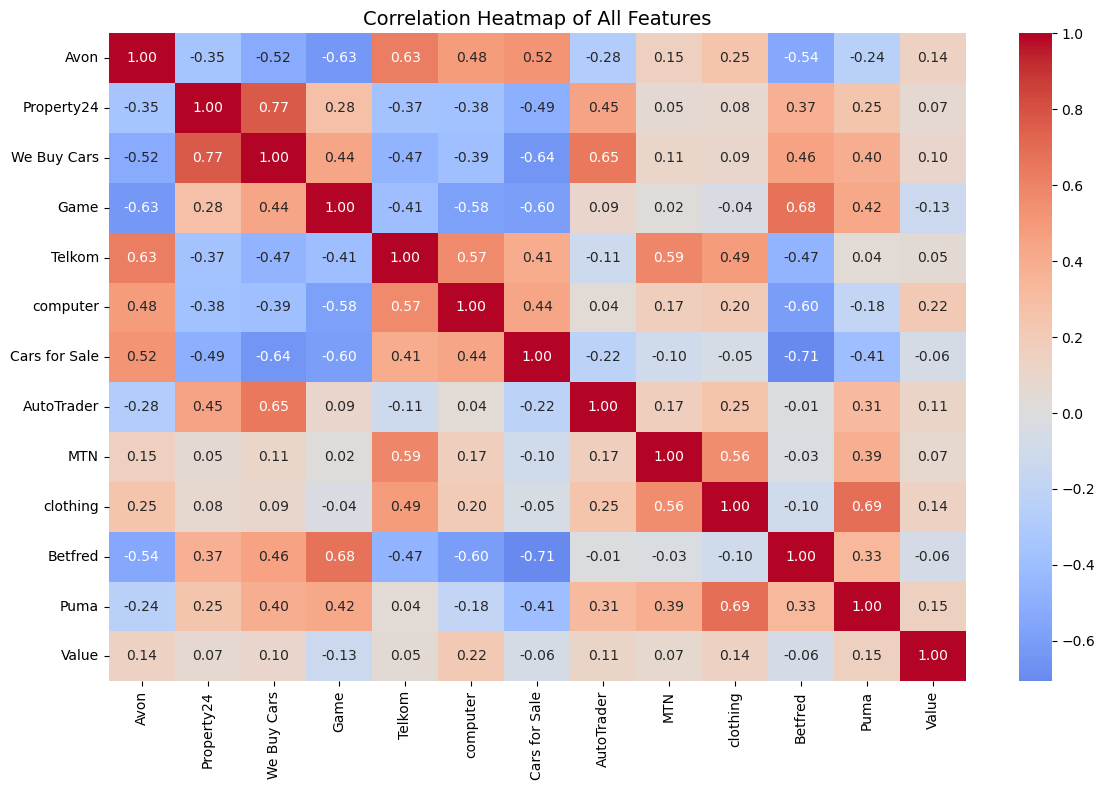

In [297]:

# Correlation heatmap
correlation_matrix = merged_df.corr()
# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title("Correlation Heatmap of All Features", fontsize=14)
plt.tight_layout()
plt.show()


In [298]:
def check_stationarity(series, signif=0.05):
    result = adfuller(series.dropna())
    p_value = result[1]
    return p_value < signif  # True if stationary


stationary_cols = []
nonstationary_cols = []

for col in merged_df.columns:
    if merged_df[col].dtype in ['float64','int64']:
        if check_stationarity(merged_df[col]):
            stationary_cols.append(col)
        else:
            nonstationary_cols.append(col)

print("Stationary columns:", stationary_cols)
print("Non-stationary columns:", nonstationary_cols)


Stationary columns: ['MTN', 'clothing', 'Puma', 'Value']
Non-stationary columns: ['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'computer', 'Cars for Sale', 'AutoTrader', 'Betfred']


In [299]:
merged_df.head()

Avon  Property24  We Buy Cars  Game  Telkom  computer  \
date                                                                
2018-12-30    34          23            7    11      61        13   
2018-12-31    29          22            5    13      72        11   
2019-01-01    39          30            9    13      58        12   
2019-01-02    42          31           11    13      81        14   
2019-01-03    45          34           13    12      71        17   

            Cars for Sale  AutoTrader  MTN  clothing  Betfred  Puma  \
date                                                                  
2018-12-30             25          17   29        63        0    19   
2018-12-31             20          15   32        53        0    16   
2019-01-01             27          20   29        50        0    12   
2019-01-02             30          22   42        58        0     9   
2019-01-03             27          23   35        53        0    10   

                   Value  
date                      
2018-12-30  48229.459312  
2018-12-31  68629.143788  
2019-01-01  52162.890120  
2019-01-02  66311.844346  
2019-01-03  95740.128026

In [300]:
merged_df.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'computer',
       'Cars for Sale', 'AutoTrader', 'MTN', 'clothing', 'Betfred', 'Puma',
       'Value'],
      dtype='object')

In [301]:
len(merged_df.columns)

13

In [302]:
merged_df.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'computer',
       'Cars for Sale', 'AutoTrader', 'MTN', 'clothing', 'Betfred', 'Puma',
       'Value'],
      dtype='object')

In [303]:
# --- Feature Engineering ---

# Lag features for the target variable
merged_df['value_lag_1'] = merged_df['Value'].shift(1)
merged_df['value_lag_2'] = merged_df['Value'].shift(2)  # Weekly seasonality




In [304]:
merged_df.head()

Avon  Property24  We Buy Cars  Game  Telkom  computer  \
date                                                                
2018-12-30    34          23            7    11      61        13   
2018-12-31    29          22            5    13      72        11   
2019-01-01    39          30            9    13      58        12   
2019-01-02    42          31           11    13      81        14   
2019-01-03    45          34           13    12      71        17   

            Cars for Sale  AutoTrader  MTN  clothing  Betfred  Puma  \
date                                                                  
2018-12-30             25          17   29        63        0    19   
2018-12-31             20          15   32        53        0    16   
2019-01-01             27          20   29        50        0    12   
2019-01-02             30          22   42        58        0     9   
2019-01-03             27          23   35        53        0    10   

                   Value   value_lag_1   value_lag_2  
date                                                  
2018-12-30  48229.459312           NaN           NaN  
2018-12-31  68629.143788  48229.459312           NaN  
2019-01-01  52162.890120  68629.143788  48229.459312  
2019-01-02  66311.844346  52162.890120  68629.143788  
2019-01-03  95740.128026  66311.844346  52162.890120

In [305]:
#drop missing values 
merged_df = merged_df.dropna()

#check for missing values 
merged_df.isna().sum()

Avon             0
Property24       0
We Buy Cars      0
Game             0
Telkom           0
computer         0
Cars for Sale    0
AutoTrader       0
MTN              0
clothing         0
Betfred          0
Puma             0
Value            0
value_lag_1      0
value_lag_2      0
dtype: int64

In [306]:
print("New features created:")
print(merged_df.columns.tolist())
print(f"New shape: {merged_df.shape}")


New features created:
['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'computer', 'Cars for Sale', 'AutoTrader', 'MTN', 'clothing', 'Betfred', 'Puma', 'Value', 'value_lag_1', 'value_lag_2']
New shape: (2351, 15)


# Spliting data

In [307]:
# Use processed DataFrame with lags and Box-Cox
df_final = merged_df.copy()

# Split indices
n = len(df_final)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

# Split into train, validation, and test sets
train = df_final.iloc[:train_end].copy()
val   = df_final.iloc[train_end:val_end].copy()
test  = df_final.iloc[val_end:].copy()

# Print shapes
print("Processed DataFrame shape:", df_final.shape)
print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)


Processed DataFrame shape: (2351, 15)
Train shape: (1645, 15)
Validation shape: (353, 15)
Test shape: (353, 15)


In [308]:
train.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'computer',
       'Cars for Sale', 'AutoTrader', 'MTN', 'clothing', 'Betfred', 'Puma',
       'Value', 'value_lag_1', 'value_lag_2'],
      dtype='object')

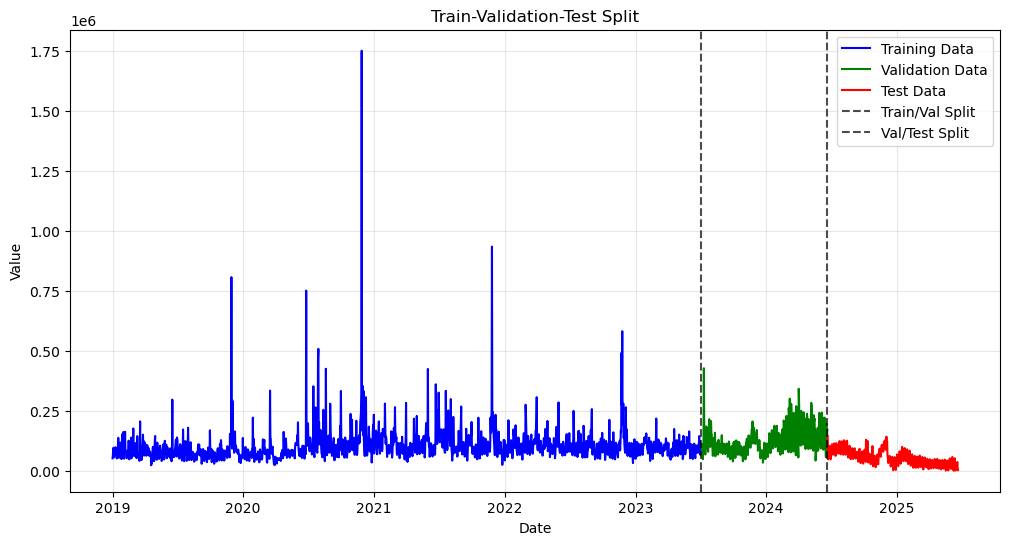

In [309]:
# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Value'], label='Training Data', color='blue')
plt.plot(val.index, val['Value'], label='Validation Data', color='green')
plt.plot(test.index, test['Value'], label='Test Data', color='red')

# Add vertical lines to show splits
plt.axvline(x=train.index.max(), color='black', linestyle='--', alpha=0.7, label='Train/Val Split')
plt.axvline(x=val.index.max(), color='black', linestyle='--', alpha=0.7, label='Val/Test Split')

plt.title('Train-Validation-Test Split')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [310]:
# detect and limit extreme outliers
def causal_winsorize(s: pd.Series, window=30, z_thresh=6.0):
    roll_med = s.rolling(window=window, min_periods=1).median()
    roll_mad = (s - roll_med).abs().rolling(window=window, min_periods=1).median() + 1e-9
    z = (s - roll_med) / roll_mad
    return s.where(z.abs() < z_thresh, roll_med)


# apply causal winsorization to validation and test sets
def causal_from_history(future_df, history_df, cols, window=30, z_thresh=6.0):
    out = {}
    for c in cols:
        joined = pd.concat([history_df[c], future_df[c]])
        capped = causal_winsorize(joined, window=window, z_thresh=z_thresh)
        out[c] = capped.iloc[len(history_df):]  # only take future_df portion
    return pd.DataFrame(out, index=future_df.index)



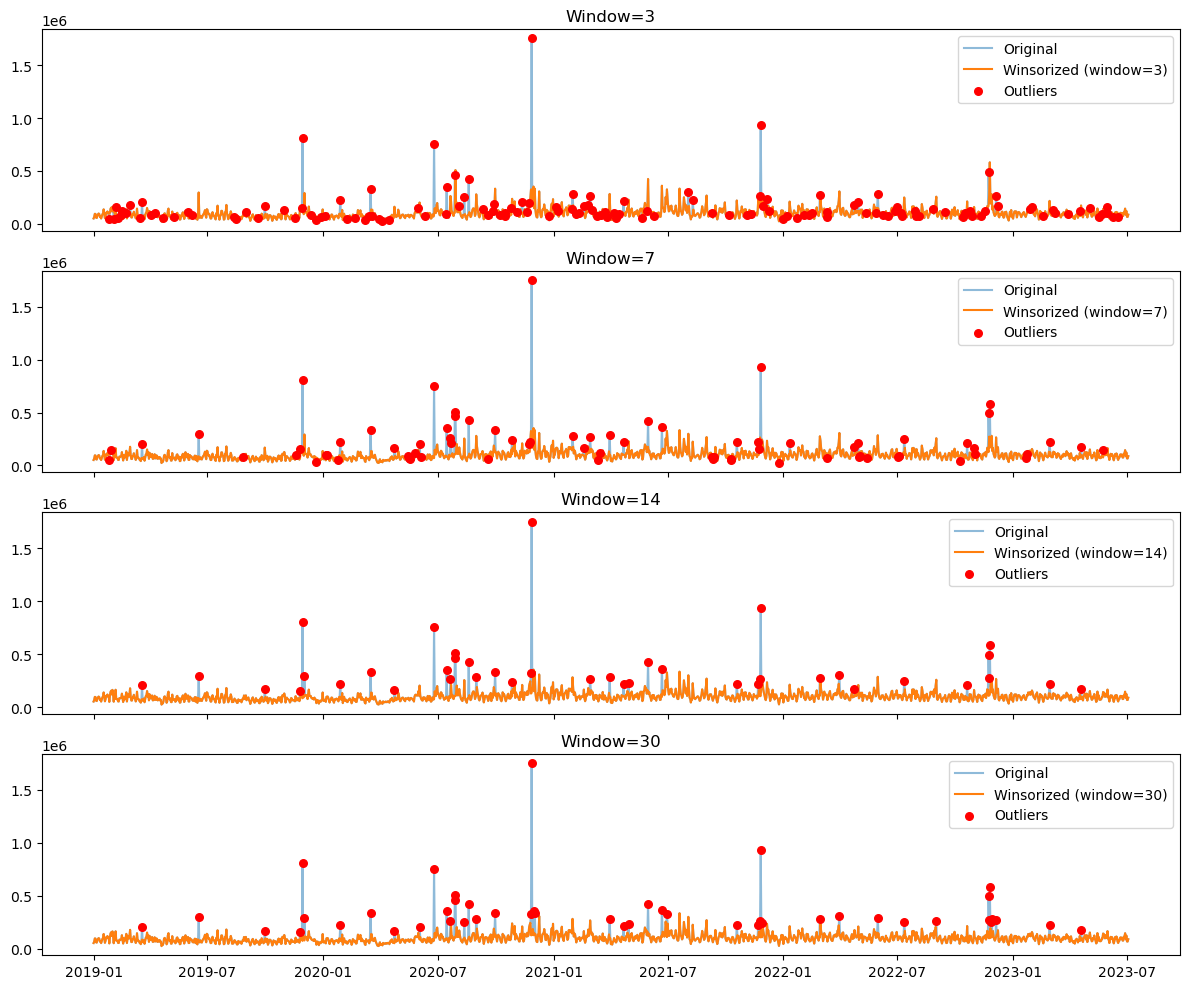

In [311]:
# Candidate windows to test
candidate_windows = [3, 7, 14, 30]
col = "Value"

fig, axes = plt.subplots(len(candidate_windows), 1, figsize=(12, 10), sharex=True)

for i, w in enumerate(candidate_windows):
    capped = causal_winsorize(train[col], window=w, z_thresh=6.0)
    
    # Detect outliers (where original != capped)
    outliers = train[col][train[col] != capped]
    
    axes[i].plot(train[col], label="Original", alpha=0.5)
    axes[i].plot(capped, label=f"Winsorized (window={w})")
    axes[i].scatter(outliers.index, outliers.values, color='red', label='Outliers', s=30, zorder=5)
    
    axes[i].legend()
    axes[i].set_title(f"Window={w}")

plt.tight_layout()
plt.show()


In [312]:
# Applies the causal_winsorize function to each predictor column

exog_cols = [c for c in train.columns if c != 	'Value']  # target separate
train_exog = train[exog_cols].apply(causal_winsorize)


# apply causal winsorization to validation and test sets
val_exog   = causal_from_history(val, train, exog_cols)
test_exog  = causal_from_history(test, pd.concat([train, val]), exog_cols)


# --- Verify shapes ---
print("Train exogenous shape:", train_exog.shape)
print("Validation exogenous shape:", val_exog.shape)
print("Test exogenous shape:", test_exog.shape)

Train exogenous shape: (1645, 14)
Validation exogenous shape: (353, 14)
Test exogenous shape: (353, 14)


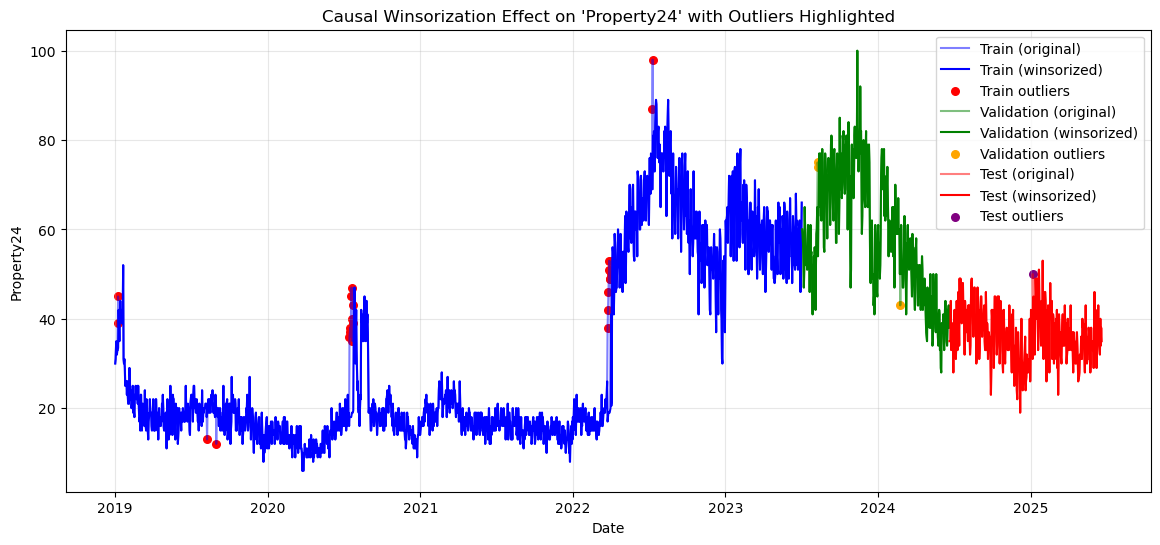

In [313]:
# Choose a column to plot
col_to_plot = exog_cols[1]  # first predictor column, change if needed

plt.figure(figsize=(14,6))

# Original and winsorized train values
plt.plot(train.index, train[col_to_plot], label='Train (original)', color='blue', alpha=0.5)
plt.plot(train.index, train_exog[col_to_plot], label='Train (winsorized)', color='blue')

# Mark outliers in train
train_outliers = train[col_to_plot][train[col_to_plot] != train_exog[col_to_plot]]
plt.scatter(train_outliers.index, train_outliers.values, color='red', s=30, label='Train outliers')

# Original and winsorized validation values
plt.plot(val.index, val[col_to_plot], label='Validation (original)', color='green', alpha=0.5)
plt.plot(val.index, val_exog[col_to_plot], label='Validation (winsorized)', color='green')

# Mark outliers in validation
val_outliers = val[col_to_plot][val[col_to_plot] != val_exog[col_to_plot]]
plt.scatter(val_outliers.index, val_outliers.values, color='orange', s=30, label='Validation outliers')

# Original and winsorized test values
plt.plot(test.index, test[col_to_plot], label='Test (original)', color='red', alpha=0.5)
plt.plot(test.index, test_exog[col_to_plot], label='Test (winsorized)', color='red')

# Mark outliers in test
test_outliers = test[col_to_plot][test[col_to_plot] != test_exog[col_to_plot]]
plt.scatter(test_outliers.index, test_outliers.values, color='purple', s=30, label='Test outliers')

plt.title(f"Causal Winsorization Effect on '{col_to_plot}' with Outliers Highlighted")
plt.xlabel('Date')
plt.ylabel(col_to_plot)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [314]:
train.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'computer',
       'Cars for Sale', 'AutoTrader', 'MTN', 'clothing', 'Betfred', 'Puma',
       'Value', 'value_lag_1', 'value_lag_2'],
      dtype='object')

In [315]:
from scipy.signal import savgol_filter

window = 31   # smoothing window (must be odd)
polyorder = 2 # polynomial order

# Automatically select all numeric columns
cols_to_denoise = train.select_dtypes(include='number').columns.tolist()

for col in cols_to_denoise:
    train[f'{col}_denoised'] = savgol_filter(train[col], window_length=window, polyorder=polyorder, mode='interp')
    val[f'{col}_denoised']   = savgol_filter(val[col],   window_length=window, polyorder=polyorder, mode='interp')
    test[f'{col}_denoised']  = savgol_filter(test[col],  window_length=window, polyorder=polyorder, mode='interp')

# Verify a few denoised columns
train[[f'{c}_denoised' for c in cols_to_denoise[:5]]].head()


Avon_denoised  Property24_denoised  We Buy Cars_denoised  \
date                                                                   
2019-01-01      38.639663            30.152859             10.765762   
2019-01-02      38.641569            31.777933             10.948094   
2019-01-03      38.705830            33.264986             11.122967   
2019-01-04      38.832445            34.614021             11.290383   
2019-01-05      39.021415            35.825035             11.450341   

            Game_denoised  Telkom_denoised  
date                                        
2019-01-01      12.580279        68.744868  
2019-01-02      12.240029        68.537023  
2019-01-03      11.916516        68.351995  
2019-01-04      11.609738        68.189782  
2019-01-05      11.319696        68.050384

In [316]:
train.shape

(1645, 30)

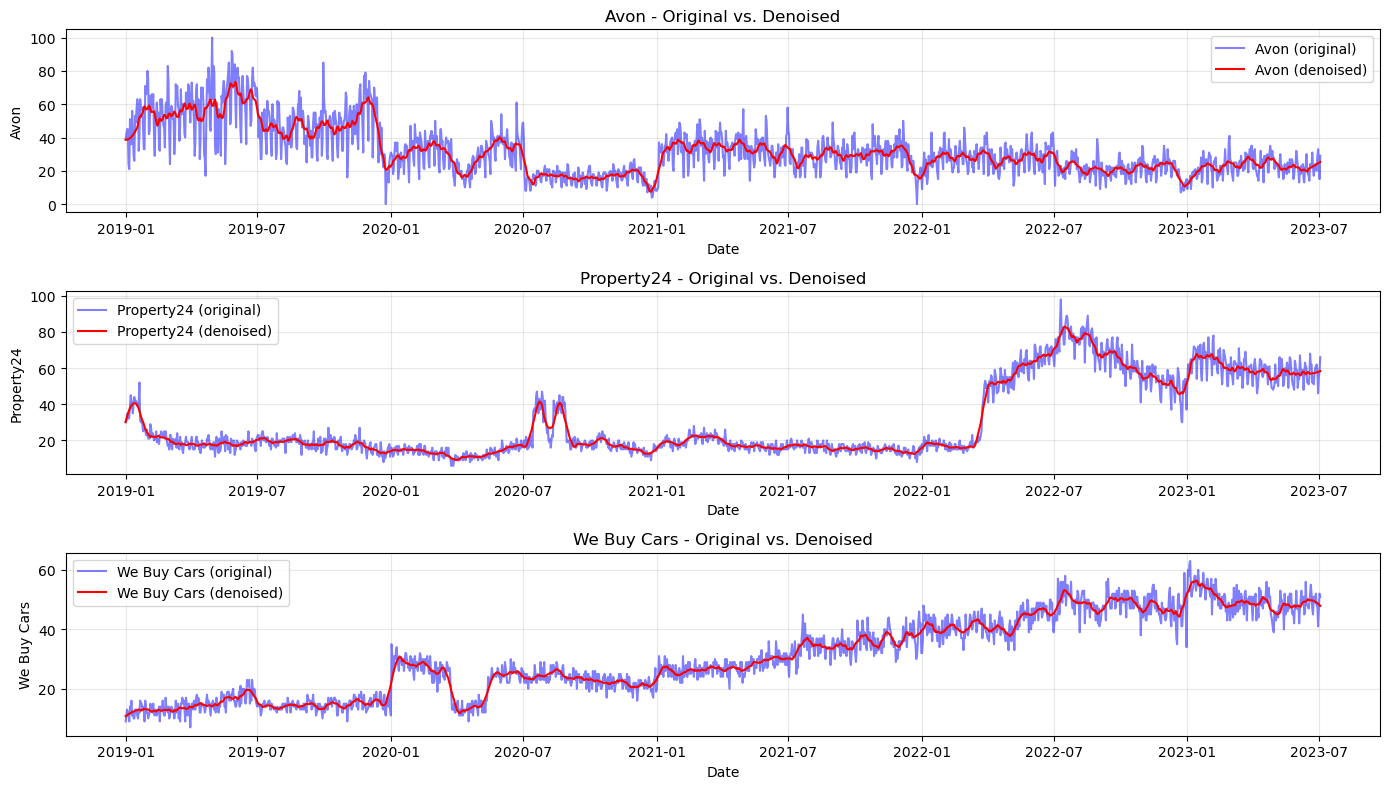

In [317]:
# Select first 3 numeric columns for plotting
cols_to_plot = cols_to_denoise[:3]

plt.figure(figsize=(14, 8))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(train.index, train[col], label=f'{col} (original)', color='blue', alpha=0.5)
    plt.plot(train.index, train[f'{col}_denoised'], label=f'{col} (denoised)', color='red')
    plt.title(f'{col} - Original vs. Denoised')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


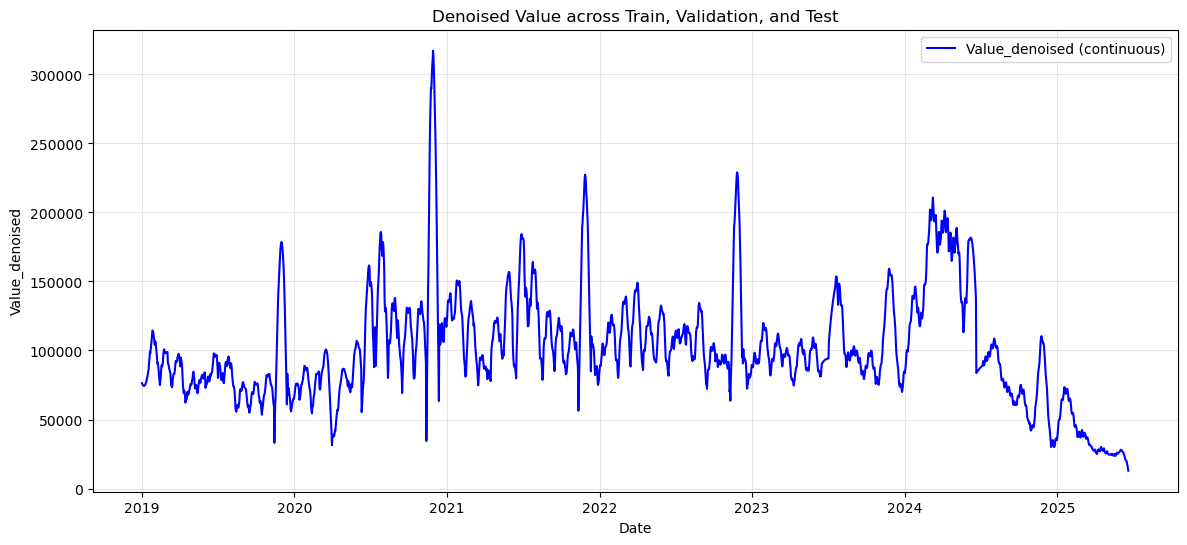

In [318]:
import matplotlib.pyplot as plt
import pandas as pd

# Concatenate train, val, test for continuous plotting
full_series = pd.concat([
    train['Value_denoised'],
    val['Value_denoised'],
    test['Value_denoised']
])

plt.figure(figsize=(14,6))
plt.plot(full_series.index, full_series.values, color='blue', label='Value_denoised (continuous)')
plt.title('Denoised Value across Train, Validation, and Test')
plt.xlabel('Date')
plt.ylabel('Value_denoised')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [319]:
# Keep only denoised columns
train = train[[col for col in train.columns if col.endswith('_denoised')]]
val   = val[[col for col in val.columns if col.endswith('_denoised')]]
test  = test[[col for col in test.columns if col.endswith('_denoised')]]

# Optional: rename columns to remove '_denoised' suffix
#train.columns = [col.replace('_denoised','') for col in train.columns]
#val.columns   = [col.replace('_denoised','') for col in val.columns]
#test.columns  = [col.replace('_denoised','') for col in test.columns]

# Verify
print("Train columns:", train.columns)
print("Validation columns:", val.columns)
print("Test columns:", test.columns)


Train columns: Index(['Avon_denoised', 'Property24_denoised', 'We Buy Cars_denoised',
       'Game_denoised', 'Telkom_denoised', 'computer_denoised',
       'Cars for Sale_denoised', 'AutoTrader_denoised', 'MTN_denoised',
       'clothing_denoised', 'Betfred_denoised', 'Puma_denoised',
       'Value_denoised', 'value_lag_1_denoised', 'value_lag_2_denoised'],
      dtype='object')
Validation columns: Index(['Avon_denoised', 'Property24_denoised', 'We Buy Cars_denoised',
       'Game_denoised', 'Telkom_denoised', 'computer_denoised',
       'Cars for Sale_denoised', 'AutoTrader_denoised', 'MTN_denoised',
       'clothing_denoised', 'Betfred_denoised', 'Puma_denoised',
       'Value_denoised', 'value_lag_1_denoised', 'value_lag_2_denoised'],
      dtype='object')
Test columns: Index(['Avon_denoised', 'Property24_denoised', 'We Buy Cars_denoised',
       'Game_denoised', 'Telkom_denoised', 'computer_denoised',
       'Cars for Sale_denoised', 'AutoTrader_denoised', 'MTN_denoised',
       '

In [320]:
# Function to check stationarity
def check_stationarity(series, series_name='Series'):
    result = adfuller(series.dropna())
    print(f"ADF Test for {series_name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    #print("Critical Values:")
    for key, value in result[4].items():
       print(f"   {key}: {value}")
    if result[1] < 0.05:
        print(f"Result: {series_name} is stationary \n")
    else:
        print(f"Result: {series_name} is non-stationary \n")

# Check stationarity for train, validation, and test sets
datasets = [('Train', train), ('Validation', val), ('Test', test)]

for name, df in datasets:
    check_stationarity(df['Value_denoised'], f"{name} Denoised")

ADF Test for Train Denoised:
ADF Statistic: -4.517012642542479
p-value: 0.00018318012166841638
   1%: -3.4343855346462084
   5%: -2.863322454682502
   10%: -2.567718940693489
Result: Train Denoised is stationary 

ADF Test for Validation Denoised:
ADF Statistic: -1.3484476176786233
p-value: 0.6067265649506576
   1%: -3.449962981927952
   5%: -2.870180642420163
   10%: -2.5713734527352607
Result: Validation Denoised is non-stationary 

ADF Test for Test Denoised:
ADF Statistic: -0.7016521542472333
p-value: 0.8463211284327876
   1%: -3.4500219858626227
   5%: -2.870206553997666
   10%: -2.571387268879483
Result: Test Denoised is non-stationary 



In [321]:
train.columns

Index(['Avon_denoised', 'Property24_denoised', 'We Buy Cars_denoised',
       'Game_denoised', 'Telkom_denoised', 'computer_denoised',
       'Cars for Sale_denoised', 'AutoTrader_denoised', 'MTN_denoised',
       'clothing_denoised', 'Betfred_denoised', 'Puma_denoised',
       'Value_denoised', 'value_lag_1_denoised', 'value_lag_2_denoised'],
      dtype='object')

In [322]:
# Update exogenous predictor list to existing columns
exog_cols = [c for c in train.columns if c not in ['Value_denoised', 'value_lag_1_denoised', 'value_lag_2_denoised']]  # or just use all remaining columns

# Compute noise statistics
noise_stats = train[exog_cols].agg(['mean', 'std', 'max', 'min']).T
noise_stats['std_to_mean'] = noise_stats['std'] / (noise_stats['mean'] + 1e-9)
noise_stats_sorted = noise_stats.sort_values('std_to_mean', ascending=False)

noise_stats_sorted

mean        std        max        min  \
Betfred_denoised         0.297297   0.693330   3.711510  -0.041056   
Property24_denoised     30.189903  20.382565  82.916574   9.106886   
We Buy Cars_denoised    30.877091  13.087855  56.356760  10.765762   
Avon_denoised           31.382247  12.935567  73.356962   7.405501   
Telkom_denoised         44.828400  16.406312  78.035595  19.176863   
Puma_denoised           14.279093   4.921209  28.480635   5.712205   
clothing_denoised       52.762187  17.406997  90.103853  21.229851   
MTN_denoised            32.024972  10.083958  52.851148  12.675094   
computer_denoised       18.518573   4.170703  28.888765   9.584083   
Game_denoised           13.206122   2.494749  20.972191   8.387704   
AutoTrader_denoised     27.834778   5.245491  37.184548  14.524118   
Cars for Sale_denoised  22.653424   3.750675  30.060269  15.520174   

                        std_to_mean  
Betfred_denoised           2.332112  
Property24_denoised        0.675145  
We Buy Cars_denoised       0.423869  
Avon_denoised              0.412194  
Telkom_denoised            0.365980  
Puma_denoised              0.344644  
clothing_denoised          0.329914  
MTN_denoised               0.314878  
computer_denoised          0.225217  
Game_denoised              0.188909  
AutoTrader_denoised        0.188451  
Cars for Sale_denoised     0.165568

In [323]:
# --- Define predictors and target ---
exog_cols = [c for c in train.columns if c not in ['Value_denoised']]  # or just use all remaining columns

# Use original predictors as they are
train_exog_final = train[exog_cols].copy()
val_exog_final   = val[exog_cols].copy()
test_exog_final  = test[exog_cols].copy()

# Verify shapes
print("Train predictors shape:", train_exog_final.shape)
print("Validation predictors shape:", val_exog_final.shape)
print("Test predictors shape:", test_exog_final.shape)

Train predictors shape: (1645, 14)
Validation predictors shape: (353, 14)
Test predictors shape: (353, 14)


In [324]:
train_exog_final = train[exog_cols].copy()
val_exog_final   = val[exog_cols].copy()
test_exog_final  = test[exog_cols].copy()

# --- Fit MinMaxScaler on training set only ---
scaler_X = MinMaxScaler().fit(train_exog_final)            # predictors
scaler_y = MinMaxScaler().fit(train[['Value_denoised']])   # target

# --- Transform predictors ---
X_train = scaler_X.transform(train_exog_final)
X_val   = scaler_X.transform(val_exog_final)
X_test  = scaler_X.transform(test_exog_final)

# --- Transform target ---
y_train = scaler_y.transform(train[['Value_denoised']])
y_val   = scaler_y.transform(val[['Value_denoised']])
y_test  = scaler_y.transform(test[['Value_denoised']])

# --- Print shapes ---
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1645, 14)
y_train shape: (1645, 1)
X_val shape: (353, 14)
y_val shape: (353, 1)
X_test shape: (353, 14)
y_test shape: (353, 1)


In [325]:
# --- Convert scaled arrays back to DataFrames ---
X_train_df = pd.DataFrame(X_train, index=train.index, columns=exog_cols)
X_val_df   = pd.DataFrame(X_val,   index=val.index,   columns=exog_cols)
X_test_df  = pd.DataFrame(X_test,  index=test.index,  columns=exog_cols)

y_train_df = pd.DataFrame(y_train, index=train.index, columns=['Value_denoised'])
y_val_df   = pd.DataFrame(y_val,   index=val.index,   columns=['Value_denoised'])
y_test_df  = pd.DataFrame(y_test,  index=test.index,  columns=['Value_denoised'])

# --- Verify ---
print("X_train_df shape:", X_train_df.shape)
print("y_train_df shape:", y_train_df.shape)
print("X_val_df shape:", X_val_df.shape)
print("y_val_df shape:", y_val_df.shape)
print("X_test_df shape:", X_test_df.shape)
print("y_test_df shape:", y_test_df.shape)


X_train_df shape: (1645, 14)
y_train_df shape: (1645, 1)
X_val_df shape: (353, 14)
y_val_df shape: (353, 1)
X_test_df shape: (353, 14)
y_test_df shape: (353, 1)


In [326]:
y_train_df.head()

Value_denoised
date                      
2019-01-01        0.157348
2019-01-02        0.154579
2019-01-03        0.152489
2019-01-04        0.151078
2019-01-05        0.150347

In [327]:
X_train_df.head()

Avon_denoised  Property24_denoised  We Buy Cars_denoised  \
date                                                                   
2019-01-01       0.473593             0.285138              0.000000   
2019-01-02       0.473622             0.307155              0.003999   
2019-01-03       0.474596             0.327303              0.007835   
2019-01-04       0.476516             0.345580              0.011507   
2019-01-05       0.479382             0.361987              0.015016   

            Game_denoised  Telkom_denoised  computer_denoised  \
date                                                            
2019-01-01       0.333154         0.842152           0.277340   
2019-01-02       0.306117         0.838621           0.293731   
2019-01-03       0.280410         0.835477           0.309520   
2019-01-04       0.256032         0.832721           0.324708   
2019-01-05       0.232985         0.830353           0.339294   

            Cars for Sale_denoised  AutoTrader_denoised  MTN_denoised  \
date                                                                    
2019-01-01                0.850363             0.359820      0.524199   
2019-01-02                0.846682             0.382629      0.517929   
2019-01-03                0.843131             0.404668      0.512159   
2019-01-04                0.839709             0.425939      0.506889   
2019-01-05                0.836417             0.446440      0.502120   

            clothing_denoised  Betfred_denoised  Puma_denoised  \
date                                                             
2019-01-01           0.436781          0.010941       0.209719   
2019-01-02           0.433742          0.010941       0.210575   
2019-01-03           0.431425          0.010941       0.211528   
2019-01-04           0.429831          0.010941       0.212576   
2019-01-05           0.428959          0.010941       0.213721   

            value_lag_1_denoised  value_lag_2_denoised  
date                                                    
2019-01-01              0.144625              0.125063  
2019-01-02              0.144403              0.126725  
2019-01-03              0.144611              0.128702  
2019-01-04              0.145251              0.130995  
2019-01-05              0.146321              0.133605

In [328]:
X_train_df.columns

Index(['Avon_denoised', 'Property24_denoised', 'We Buy Cars_denoised',
       'Game_denoised', 'Telkom_denoised', 'computer_denoised',
       'Cars for Sale_denoised', 'AutoTrader_denoised', 'MTN_denoised',
       'clothing_denoised', 'Betfred_denoised', 'Puma_denoised',
       'value_lag_1_denoised', 'value_lag_2_denoised'],
      dtype='object')

In [329]:
# Create sequences using past seq_length steps to predict current step


def create_sequences(X, y, seq_length=3):
    """
    Create LSTM sequences using past seq_length steps to predict current step.
    Keeps original indices for alignment.

    Parameters:
    X : pd.DataFrame, features
    y : pd.DataFrame or Series, target
    seq_length : int, number of past timesteps

    Returns:
    X_seq : np.array, shape (num_sequences, seq_length, n_features)
    y_seq : np.array, shape (num_sequences, 1)
    seq_index : np.array, indices of y corresponding to each sequence
    """
    X_seq, y_seq, seq_index = [], [], []

    for i in range(seq_length, len(X)):
        # Take past seq_length steps of features
        X_seq.append(X.iloc[i-seq_length:i].values)

        # Take target at current time step
        y_seq.append(y.iloc[i].values if y.ndim > 1 else y.iloc[i])

        # Store the corresponding index
        seq_index.append(X.index[i])

    return np.array(X_seq), np.array(y_seq), np.array(seq_index)


In [330]:
SEQ_LENGTH = 3  # Using past 30 days to predict next day

X_train_seq, y_train_seq, idx_train_seq = create_sequences(X_train_df, y_train_df, SEQ_LENGTH)
X_val_seq, y_val_seq, idx_val_seq       = create_sequences(X_val_df, y_val_df, SEQ_LENGTH)
X_test_seq, y_test_seq, idx_test_seq    = create_sequences(X_test_df, y_test_df, SEQ_LENGTH)

# Print shapes
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("Number of indices:", len(idx_train_seq))

X_train_seq shape: (1642, 3, 14)
y_train_seq shape: (1642, 1)
Number of indices: 1642


In [331]:
print("First sequence shape:", X_test_seq[0].shape)
print("Target of first sequence:", y_test_seq[0])
print("Original index of first sequence target:", idx_test_seq[0])

First sequence shape: (3, 14)
Target of first sequence: [0.18767098]
Original index of first sequence target: 2024-06-24 00:00:00


In [332]:
# HELPING FUCTIONS

# training history ploting function
def plot_history(histories, names):
    plt.figure(figsize=(18,6))
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{names[i]} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{names[i]} Val Loss', linestyle='--')
    plt.title('Deep Learning Model Training History (MSE Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# orediction ploting function
def plot_predictions(idx_val, y_val_true, y_val_pred,
                     idx_test, y_test_true, y_test_pred,
                     title='Model Predictions vs True Values'):
    plt.figure(figsize=(16,6))

    # Validation
    plt.plot(idx_val, y_val_true, label='Validation True', color='blue')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')

    # Test
    plt.plot(idx_test, y_test_true, label='Test True', color='green')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True   )
    plt.legend()
    plt.show()
   
# evaluation fuction
def evaluate_predictions(y_true, y_pred, set_name='Test'):
    print(f"Evaluation Metrics for {set_name} Set:")
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Print metrics 
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    
    metrics_dict = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics_dict


# EarlyStopping callback
early_stop = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]


# Hyperparameters
n_features = X_train_seq.shape[2]   # number of features in input
SEQ_LENGTH = X_train_seq.shape[1]   # timesteps
Epochs = 100
Batch_size = 32


# ARIMAX

In [333]:
import pmdarima as pm

# Automatically select ARIMA order (p,d,q)
auto_model = pm.auto_arima(
    y_train_df, 
    exogenous=X_train_df,
    seasonal=False,        # change to True if seasonality exists
    stepwise=True,         # faster search
    suppress_warnings=True,
    max_p=5, max_q=5, max_d=2
)

print(auto_model.summary())
print("Suggested order:", auto_model.order)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1645
Model:               SARIMAX(1, 1, 1)   Log Likelihood                4299.513
Date:                Wed, 24 Sep 2025   AIC                          -8593.026
Time:                        12:51:03   BIC                          -8576.812
Sample:                    01-01-2019   HQIC                         -8587.013
                         - 07-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7270      0.014     51.808      0.000       0.699       0.754
ma.L1         -0.2893      0.014    -20.001      0.000      -0.318      -0.261
sigma2         0.0003   3.17e-06     98.818      0.0

In [334]:
# Define ARIMAX model
arimax_model = SARIMAX(
    endog=y_train_df,        # target
    exog=X_train_df,         # exogenous features
    order=(3,1,2),           # ARIMA order (p,d,q)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
arimax_result = arimax_model.fit(disp=False)

# Print model summary
print(arimax_result.summary())

                               SARIMAX Results                                
Dep. Variable:         Value_denoised   No. Observations:                 1645
Model:               SARIMAX(3, 1, 2)   Log Likelihood                4415.880
Date:                Wed, 24 Sep 2025   AIC                          -8791.760
Time:                        12:51:09   BIC                          -8683.699
Sample:                    01-01-2019   HQIC                         -8751.684
                         - 07-03-2023                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Avon_denoised              0.3231      0.050      6.495      0.000       0.226       0.421
Property24_denoised        0.2484      0.068      3.646      0.000       0.115       0.382
We B

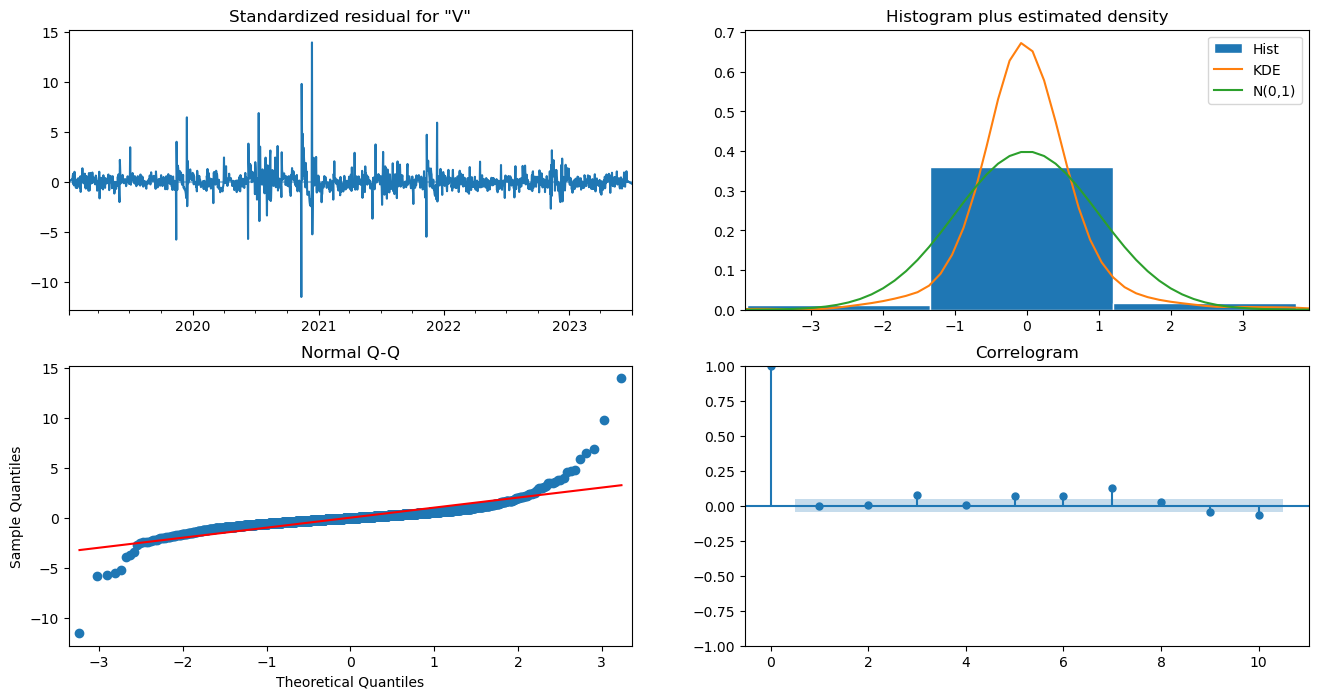

In [335]:
arimax_result.plot_diagnostics(figsize=(16, 8))
plt.show()


In [336]:
# --- Validation predictions ---
y_val_pred_arimax = arimax_result.get_forecast(steps=len(X_val_df), exog=X_val_df).predicted_mean

# Inverse-transform
y_val_true_arimax = scaler_y.inverse_transform(y_val_df)
y_val_pred_arimax_rescaled = scaler_y.inverse_transform(y_val_pred_arimax.values.reshape(-1,1))

# --- Test predictions ---
y_test_pred_arimax = arimax_result.get_forecast(steps=len(X_test_df), exog=X_test_df).predicted_mean

# Inverse-transform
y_test_true_arimax = scaler_y.inverse_transform(y_test_df)
y_test_pred_arimax_rescaled = scaler_y.inverse_transform(y_test_pred_arimax.values.reshape(-1,1))


In [337]:
metrics_val_arimax = evaluate_predictions(y_val_true_arimax, y_val_pred_arimax_rescaled, set_name='Validation')
metrics_test_arimax = evaluate_predictions(y_test_true_arimax, y_test_pred_arimax_rescaled, set_name='Test')

# Extract RMSE, MAE, R² for comparison
rmse_arimax = metrics_test_arimax['RMSE']
mae_arimax  = metrics_test_arimax['MAE']
r2_arimax   = metrics_test_arimax['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_arimax_val = metrics_val_arimax['RMSE']
mae_arimax_val  = metrics_val_arimax['MAE']
r2_arimax_val   = metrics_val_arimax['R2']


Evaluation Metrics for Validation Set:
MAE: 48321.7773
RMSE: 55125.3741
R2: -1.0686
Evaluation Metrics for Test Set:
MAE: 34344.4742
RMSE: 40368.4906
R2: -1.3712


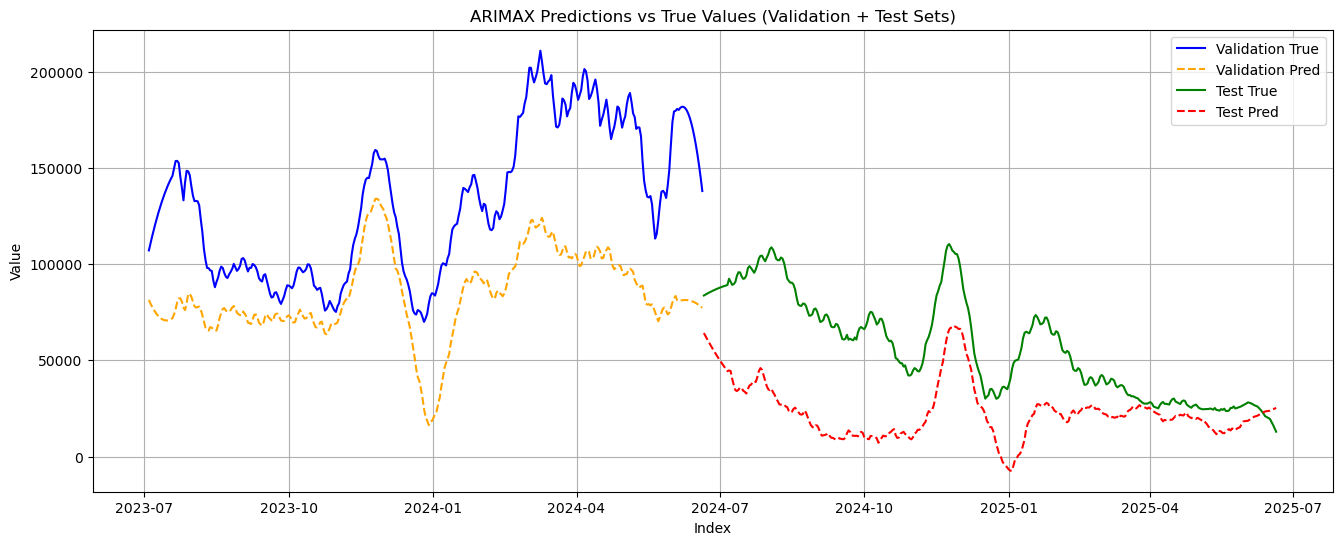

In [338]:
# Validation indices
idx_val_arimax = X_val_df.index
# Test indices
idx_test_arimax = X_test_df.index

# Plot ARIMAX predictions
plot_predictions(
    idx_val_arimax, y_val_true_arimax, y_val_pred_arimax_rescaled,
    idx_test_arimax, y_test_true_arimax, y_test_pred_arimax_rescaled,
    title='ARIMAX Predictions vs True Values (Validation + Test Sets)'
)

# LSTM

In [339]:
def build_lstm(seq_length, n_features):
    model = Sequential()
    
    # First LSTM layer with L2 regularization + dropout
    model.add(LSTM(
        64, 
        activation='tanh', 
        return_sequences=True, 
        input_shape=(seq_length, n_features),
        kernel_regularizer=regularizers.l2(0.001),   # L2 penalty
        recurrent_regularizer=regularizers.l2(0.001),
        bias_regularizer=regularizers.l2(0.001)
    ))
    model.add(Dropout(0.3))  
    
    # Second LSTM layer
    model.add(LSTM(
        32,
        kernel_regularizer=regularizers.l2(0.001),
        recurrent_regularizer=regularizers.l2(0.001),
        bias_regularizer=regularizers.l2(0.001)
    ))
    model.add(Dropout(0.3))
    
    # Dense output layer with L2
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.001)))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate model
lstm_model = build_lstm(SEQ_LENGTH, n_features)
lstm_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 3, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

In [340]:
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop]
)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2945 - val_loss: 0.1899 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1681 - val_loss: 0.1378 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1170 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0931 - val_loss: 0.0998 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0789 - val_loss: 0.0851 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0697 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0605 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0542 - val_loss: 0.0720 - learning_rate: 0.0010
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0477 - val_loss: 0.0617 - learning_rate: 0.0010
Epoch 10/100
52/5

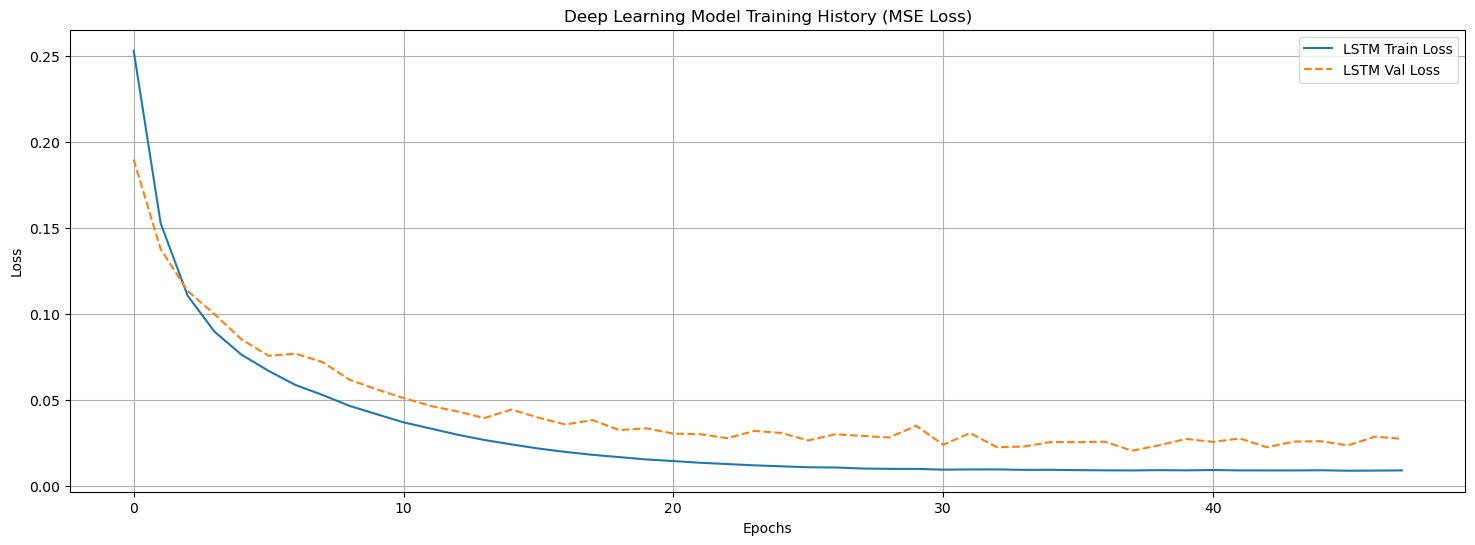

In [341]:
# Call the function
plot_history(
    histories=[history_lstm],
    names=['LSTM']
)

In [342]:
# Validation predictions
y_val_pred = lstm_model.predict(X_val_seq)
# Test predictions
y_test_pred = lstm_model.predict(X_test_seq)

# Validation DataFrame
val_pred_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred.flatten(),
}, index=idx_val_seq)

# Test DataFrame
test_pred_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred.flatten(),
}, index=idx_test_seq)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [343]:
y_val_pred_lstm_rescaled = scaler_y.inverse_transform(val_pred_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_df[['y_true']])

y_test_pred_lstm_rescaled = scaler_y.inverse_transform(test_pred_df[['y_pred']])
y_test_true_lstm_rescaled = scaler_y.inverse_transform(test_pred_df[['y_true']])



# --- Compute metrics ---
metrics_val_lstm = evaluate_predictions(y_val_true_rescaled, y_val_pred_lstm_rescaled, set_name='Validation')
metrics_test_lstm = evaluate_predictions(y_test_true_lstm_rescaled, y_test_pred_lstm_rescaled, set_name='Test')

# Extract RMSE, MAE, R² for test set
rmse_lstm = metrics_test_lstm['RMSE']
mae_lstm  = metrics_test_lstm['MAE']
r2_lstm   = metrics_test_lstm['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_lstm_val = metrics_val_lstm['RMSE']
mae_lstm_val  = metrics_val_lstm['MAE']
r2_lstm_val   = metrics_val_lstm['R2']


Evaluation Metrics for Validation Set:
MAE: 28772.0746
RMSE: 34792.2217
R2: 0.1807
Evaluation Metrics for Test Set:
MAE: 13660.4303
RMSE: 15846.3523
R2: 0.6345


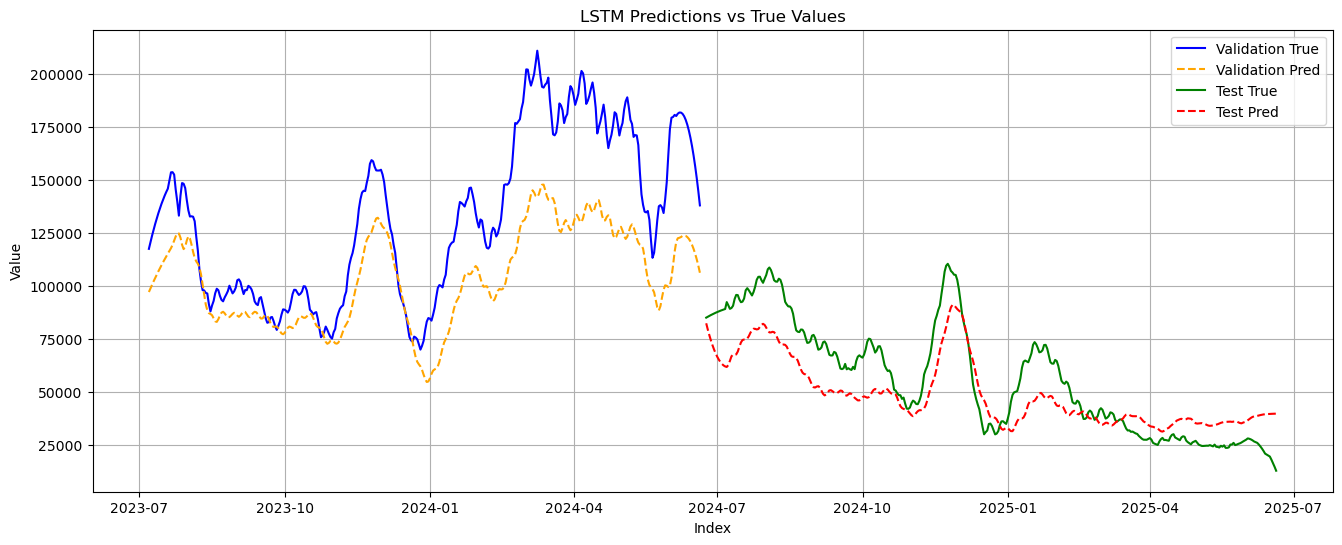

In [344]:

plot_predictions(
    idx_val_seq, y_val_true_rescaled, y_val_pred_lstm_rescaled,
    idx_test_seq, y_test_true_lstm_rescaled, y_test_pred_lstm_rescaled,
    title='LSTM Predictions vs True Values'
)


In [345]:
n_display = 10

# Take first n_display predictions and actuals
actual = y_test_true_lstm_rescaled[:n_display].flatten()
predicted = y_test_pred_lstm_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df)

        date        Actual     Predicted
0 2024-06-24  85028.946996  82372.328125
1 2024-06-25  85454.778091  79424.601562
2 2024-06-26  85864.932658  76709.234375
3 2024-06-27  86259.410697  74225.132812
4 2024-06-28  86638.212208  71971.031250
5 2024-06-29  87001.337191  69945.546875
6 2024-06-30  87348.785645  68147.226562
7 2024-07-01  87680.557571  66574.515625
8 2024-07-02  87996.652969  65225.878906
9 2024-07-03  88297.071839  64099.742188


# Bi-LSTM

In [346]:
def build_bilstm(seq_length, n_features):
    model = Sequential()
    
    # First Bidirectional LSTM with L2 regularization
    model.add(Bidirectional(
        LSTM(
            64,
            activation='tanh',
            return_sequences=True,
            kernel_regularizer=regularizers.l2(0.001),
            recurrent_regularizer=regularizers.l2(0.001),
            bias_regularizer=regularizers.l2(0.001)
        ),
        input_shape=(seq_length, n_features)
    ))
    model.add(Dropout(0.3))
    
    # Second Bi-LSTM layer
    model.add(Bidirectional(
        LSTM(
            32,
            kernel_regularizer=regularizers.l2(0.001),
            recurrent_regularizer=regularizers.l2(0.001),
            bias_regularizer=regularizers.l2(0.001)
        )
    ))
    model.add(Dropout(0.3))
    
    # Dense output with L2 regularization
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.001)))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate model
bilstm_model = build_bilstm(SEQ_LENGTH, n_features)
bilstm_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 3, 128)         │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,729 (319.25 KB)

 Trainable params: 81,729 (319.25 KB)

 Non-trainable params: 0 (0.00 B)

In [347]:
history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop]
)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.6280 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3355 - val_loss: 0.2596 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2241 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1730 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1452 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1253 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1099 - val_loss: 0.1135 - learning_rate: 0.0010
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0968 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0850 - val_loss: 0.0931 - learning_rate: 0.0010
Epoch 10/100


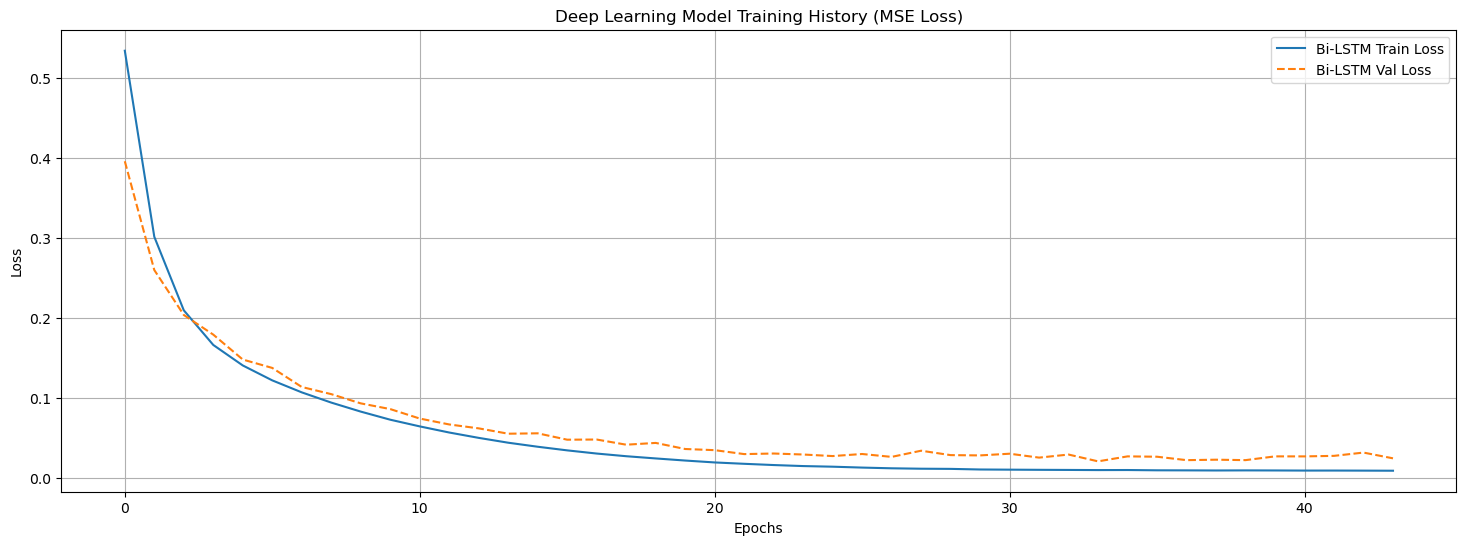

In [348]:
# plot training history
plot_history(
    histories=[history_bilstm],
    names=['Bi-LSTM']
)

In [349]:
# Validation predictions
y_val_pred_bi = bilstm_model.predict(X_val_seq)
# Test predictions
y_test_pred_bi = bilstm_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_bi_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_bi.flatten()
}, index=idx_val_seq)

test_pred_bi_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_bi.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_bi_rescaled = scaler_y.inverse_transform(val_pred_bi_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_bi_df[['y_true']])

y_test_pred_bi_rescaled = scaler_y.inverse_transform(test_pred_bi_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_bi_df[['y_true']])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [350]:
# Evaluate Bi-LSTM
metrics_val_bilstm = evaluate_predictions(y_val_true_rescaled, y_val_pred_bi_rescaled, set_name='Validation')
metrics_test_bilstm = evaluate_predictions(y_test_true_rescaled, y_test_pred_bi_rescaled, set_name='Test')

# Extract RMSE, MAE, R² for test set
rmse_bilstm = metrics_test_bilstm['RMSE']
mae_bilstm  = metrics_test_bilstm['MAE']
r2_bilstm   = metrics_test_bilstm['R2']

#Extract RMSE, MAE, R² for Validation set
rmse_bilstm_val = metrics_val_bilstm['RMSE']
mae_bilstm_val  = metrics_val_bilstm['MAE']
r2_bilstm_val   = metrics_val_bilstm['R2']

Evaluation Metrics for Validation Set:
MAE: 28296.3177
RMSE: 34650.4974
R2: 0.1874
Evaluation Metrics for Test Set:
MAE: 13085.9742
RMSE: 14734.6492
R2: 0.6840


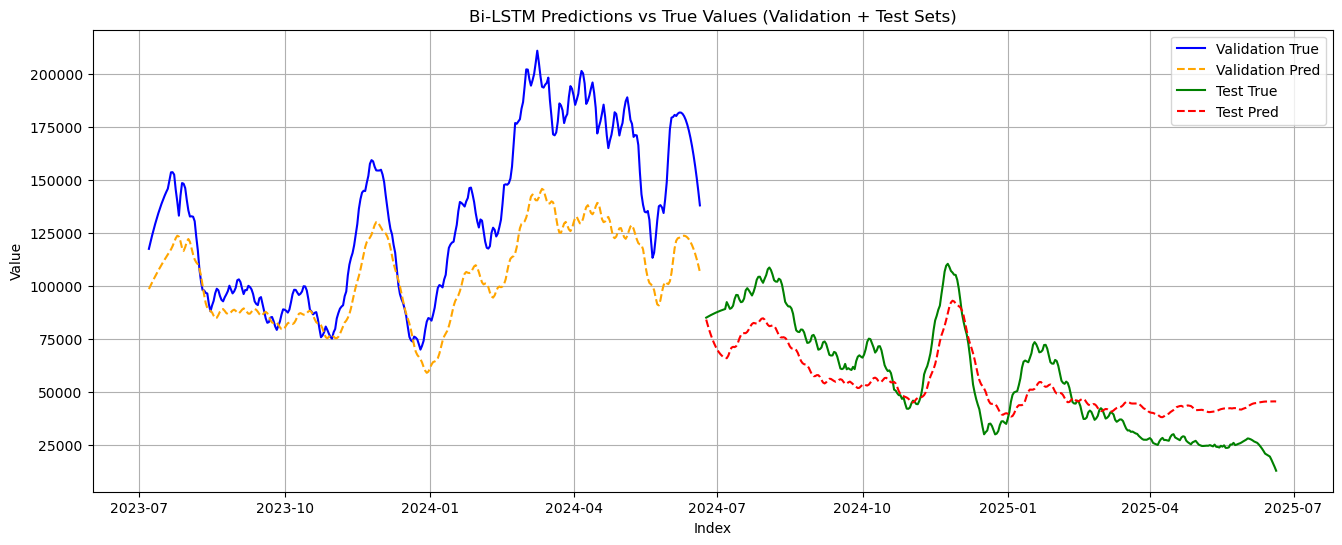

In [351]:
plot_predictions(
    idx_val_seq, y_val_true_rescaled, y_val_pred_bi_rescaled,
    idx_test_seq, y_test_true_rescaled, y_test_pred_bi_rescaled,
    title='Bi-LSTM Predictions vs True Values (Validation + Test Sets)'
)

In [352]:
n_display = 10

# Take first n_display predictions and actuals for Bi-LSTM
actual = y_test_true_rescaled[:n_display].flatten()
predicted = y_test_pred_bi_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df_bi = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df_bi)

        date        Actual     Predicted
0 2024-06-24  85028.946996  84107.187500
1 2024-06-25  85454.778091  81440.515625
2 2024-06-26  85864.932658  78991.671875
3 2024-06-27  86259.410697  76759.085938
4 2024-06-28  86638.212208  74741.031250
5 2024-06-29  87001.337191  72935.640625
6 2024-06-30  87348.785645  71340.968750
7 2024-07-01  87680.557571  69955.031250
8 2024-07-02  87996.652969  68775.851562
9 2024-07-03  88297.071839  67801.460938


# GRU

In [353]:
def build_gru(seq_length, n_features):
    model = Sequential([
        GRU(
            64,
            activation='tanh',
            return_sequences=True,
            input_shape=(seq_length, n_features),
            kernel_regularizer=regularizers.l2(0.001),
            recurrent_regularizer=regularizers.l2(0.001),
            bias_regularizer=regularizers.l2(0.001)
        ),
        Dropout(0.3),
        
        GRU(
            32,
            activation='tanh',
            kernel_regularizer=regularizers.l2(0.001),
            recurrent_regularizer=regularizers.l2(0.001),
            bias_regularizer=regularizers.l2(0.001)
        ),
        Dropout(0.3),
        
        Dense(1, kernel_regularizer=regularizers.l2(0.001))
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate and summarize
gru_model = build_gru(SEQ_LENGTH, n_features)
gru_model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 3, 64)          │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801 (96.88 KB)

 Trainable params: 24,801 (96.88 KB)

 Non-trainable params: 0 (0.00 B)

In [354]:
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2188 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1052 - val_loss: 0.1002 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0628 - val_loss: 0.0791 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0440 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0336 - val_loss: 0.0504 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0273 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0227 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0205 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 10/100
52/52

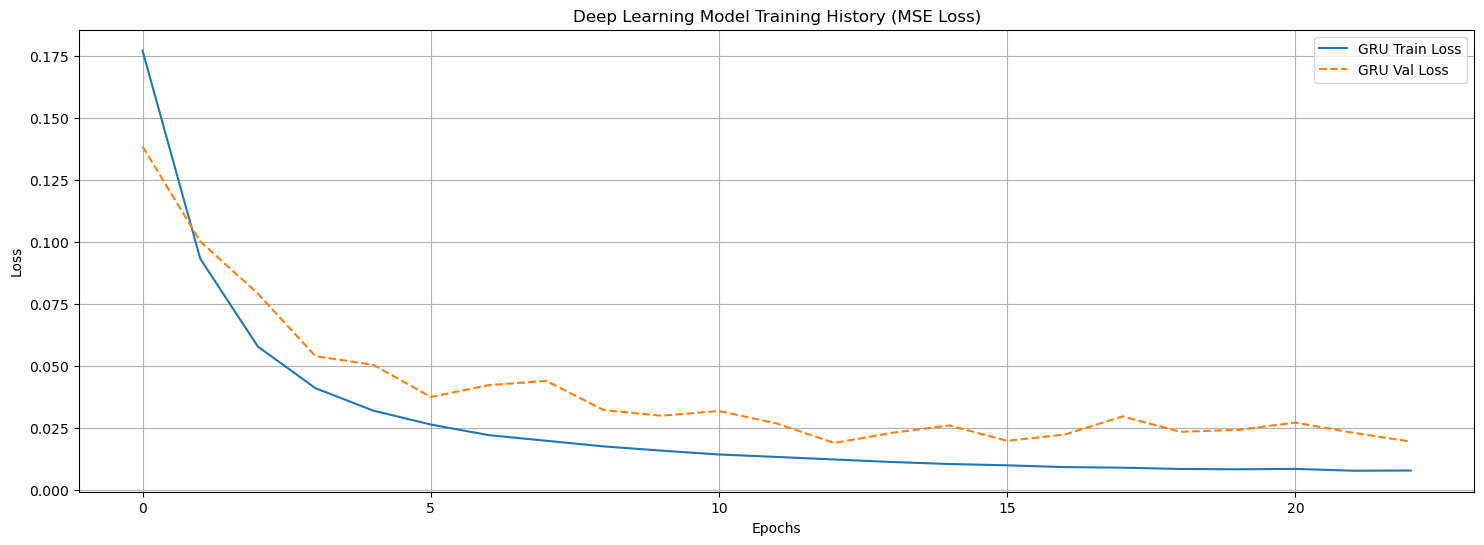

In [355]:
# Call the function
plot_history(
    histories=[history_gru],
    names=[ 'GRU']
)

In [356]:
# Validation predictions
y_val_pred_gru = gru_model.predict(X_val_seq)
# Test predictions
y_test_pred_gru = gru_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_gru_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_gru.flatten()
}, index=idx_val_seq)

test_pred_gru_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_gru.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_gru_rescaled = scaler_y.inverse_transform(val_pred_gru_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_gru_df[['y_true']])

y_test_pred_gru_rescaled = scaler_y.inverse_transform(test_pred_gru_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_gru_df[['y_true']])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [357]:
# Evaluate GRU
metrics_val_gru = evaluate_predictions(y_val_true_rescaled, y_val_pred_gru_rescaled, set_name='Validation')
metrics_test_gru = evaluate_predictions(y_test_true_rescaled, y_test_pred_gru_rescaled, set_name='Test')

# Extract RMSE, MAE, R² for test set
rmse_gru = metrics_test_gru['RMSE']
mae_gru  = metrics_test_gru['MAE']
r2_gru   = metrics_test_gru['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_gru_val = metrics_val_gru['RMSE']
mae_gru_val  = metrics_val_gru['MAE']
r2_gru_val   = metrics_val_gru['R2']


Evaluation Metrics for Validation Set:
MAE: 24646.7932
RMSE: 30056.2932
R2: 0.3886
Evaluation Metrics for Test Set:
MAE: 12059.2088
RMSE: 14320.9208
R2: 0.7015


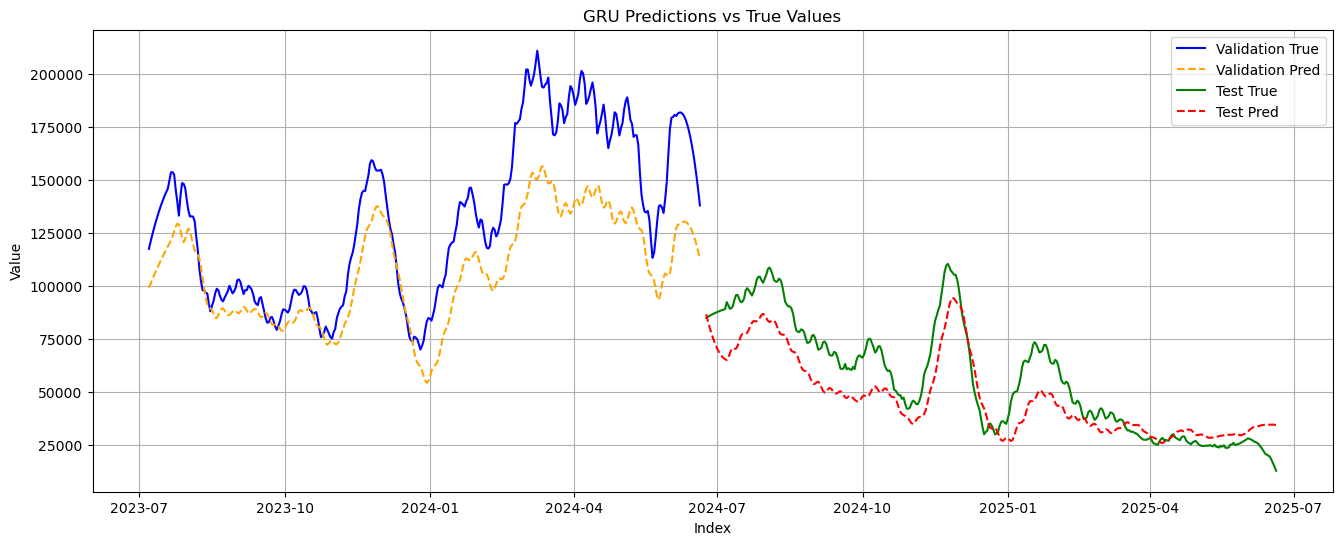

In [358]:
plot_predictions(
    idx_val_seq, y_val_true_rescaled, y_val_pred_gru_rescaled,
    idx_test_seq, y_test_true_rescaled, y_test_pred_gru_rescaled,
    title='GRU Predictions vs True Values'
)

# Bi-GRU 

In [359]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_bigru(seq_length, n_features):
    model = Sequential()
    # First Bidirectional GRU layer (reduced units)
    model.add(Bidirectional(GRU(32, activation='tanh', return_sequences=True),
                            input_shape=(seq_length, n_features)))
    model.add(Dropout(0.3))  # slightly higher dropout
    
    # Second GRU layer (smaller units)
    model.add(GRU(16, activation='tanh'))
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Dense(1, kernel_regularizer='l2'))  # add L2 regularization
    
    # Compile
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate model
bigru_model = build_bigru(SEQ_LENGTH, n_features)
bigru_model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 3, 64)          │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 16)             │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,169 (51.44 KB)

 Trainable params: 13,169 (51.44 KB)

 Non-trainable params: 0 (0.00 B)

In [360]:
history_bigru = bigru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0596 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0316 - val_loss: 0.0448 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0245 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0211 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - val_loss: 0.0397 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - val_loss: 0.0242 - learning_rate: 0.0010
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - val_loss: 0.0273 - learning_rate: 0.0010
Epoch 10/100
52/52

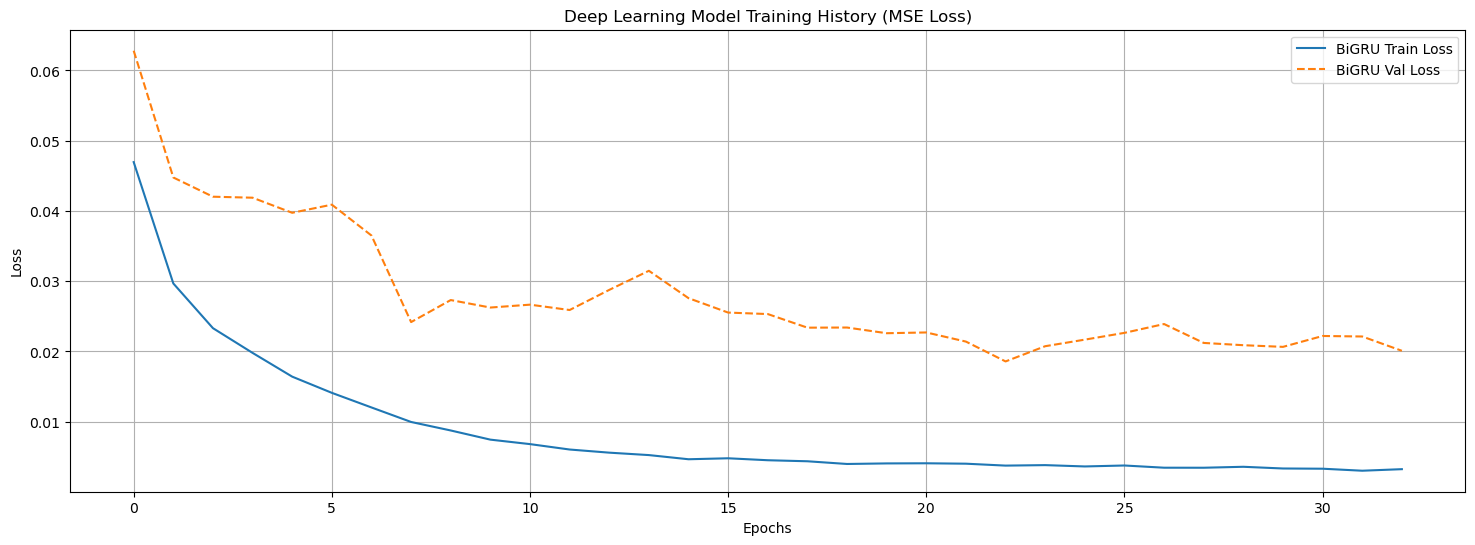

In [361]:
# Call the function
plot_history(
    histories=[history_bigru],
    names=['BiGRU']
)

In [362]:
# Validation predictions
y_val_pred_bigru = bigru_model.predict(X_val_seq)
# Test predictions
y_test_pred_bigru = bigru_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_bigru_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_bigru.flatten()
}, index=idx_val_seq)

test_pred_bigru_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_bigru.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_bigru_rescaled = scaler_y.inverse_transform(val_pred_bigru_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_bigru_df[['y_true']])

y_test_pred_bigru_rescaled = scaler_y.inverse_transform(test_pred_bigru_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_bigru_df[['y_true']])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [363]:
metrics_val_bigru = evaluate_predictions(y_val_true_rescaled, y_val_pred_bigru_rescaled, set_name='Validation')
metrics_test_bigru = evaluate_predictions(y_test_true_rescaled, y_test_pred_bigru_rescaled, set_name='Test')


# Extract RMSE, MAE, R² for test set
rmse_bigru= metrics_test_bigru['RMSE']
mae_bigru  = metrics_test_bigru['MAE']
r2_bigru  = metrics_test_bigru['R2']


# Extract metrics for Validation set
rmse_bigru_val = metrics_val_bigru['RMSE']
mae_bigru_val  = metrics_val_bigru['MAE']
r2_bigru_val   = metrics_val_bigru['R2']


Evaluation Metrics for Validation Set:
MAE: 32335.2217
RMSE: 38247.9194
R2: 0.0099
Evaluation Metrics for Test Set:
MAE: 12765.7352
RMSE: 14357.4087
R2: 0.7000


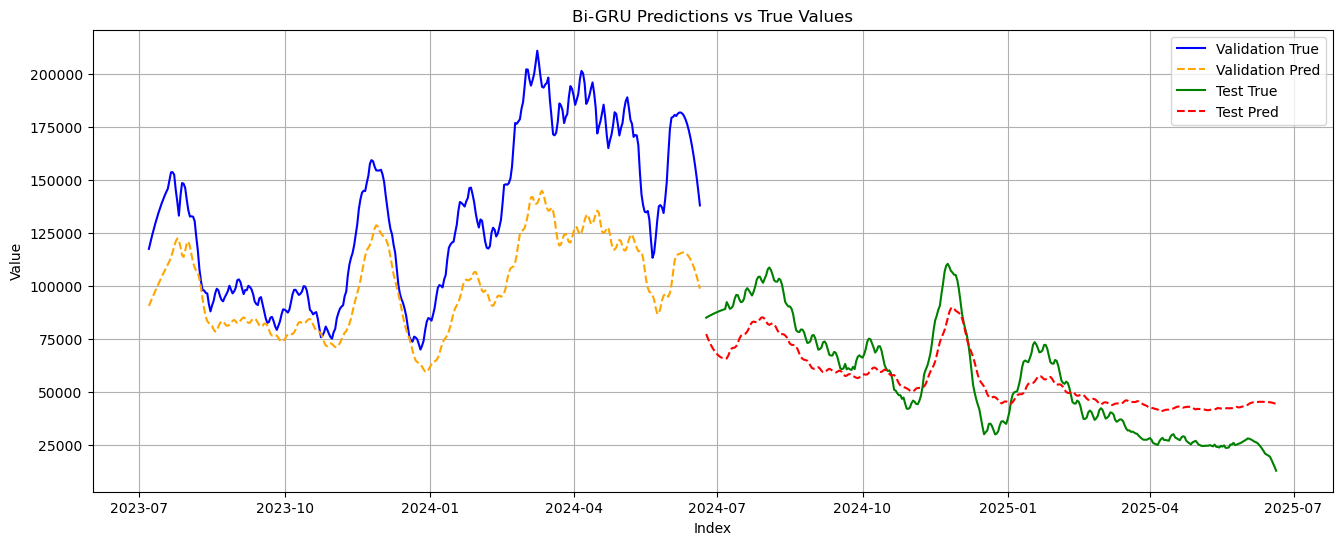

In [364]:
plot_predictions(
    idx_val_seq, y_val_true_rescaled, y_val_pred_bigru_rescaled,
    idx_test_seq, y_test_true_rescaled, y_test_pred_bigru_rescaled,
    title='Bi-GRU Predictions vs True Values'
)

# Hybrid Model 

# Results

In [365]:
# metrics for testing set
metrics_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU'],
     'Dataset': 'Test',
    'RMSE': [rmse_arimax, rmse_lstm, rmse_bilstm, rmse_gru, rmse_bigru],
    'MAE': [mae_arimax, mae_lstm, mae_bilstm, mae_gru, mae_bigru],
    'R²': [r2_arimax, r2_lstm, r2_bilstm, r2_gru, r2_bigru]
})

metrics_df


Model Dataset          RMSE           MAE        R²
0   ARIMAX    Test  40368.490594  34344.474178 -1.371179
1     LSTM    Test  15846.352257  13660.430265  0.634523
2  Bi-LSTM    Test  14734.649199  13085.974190  0.684004
3      GRU    Test  14320.920812  12059.208765  0.701501
4   Bi-GRU    Test  14357.408706  12765.735186  0.699978

In [366]:
# Metrics for Validation set
metrics_val_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU'],
    'Dataset': 'Validation',
    'RMSE': [rmse_arimax_val, rmse_lstm_val, rmse_bilstm_val, rmse_gru_val, rmse_bigru_val],
    'MAE':  [mae_arimax_val, mae_lstm_val, mae_bilstm_val, mae_gru_val, mae_bigru_val],
    'R²':   [r2_arimax_val, r2_lstm_val, r2_bilstm_val, r2_gru_val, r2_bigru_val]
})

# Display
metrics_val_df


Model     Dataset          RMSE           MAE        R²
0   ARIMAX  Validation  55125.374098  48321.777321 -1.068564
1     LSTM  Validation  34792.221663  28772.074594  0.180714
2  Bi-LSTM  Validation  34650.497429  28296.317741  0.187375
3      GRU  Validation  30056.293215  24646.793171  0.388577
4   Bi-GRU  Validation  38247.919380  32335.221698  0.009882

In [367]:
import plotly.graph_objects as go

# --- Plot actual values for train, val, test ---
fig = go.Figure()

# Actual series
fig.add_trace(go.Scatter(x=train.index, y=scaler_y.inverse_transform(y_train_df).flatten(),
                         mode='lines', name='Train Actual', line=dict(color='black')))
fig.add_trace(go.Scatter(x=val.index, y=scaler_y.inverse_transform(y_val_df).flatten(),
                         mode='lines', name='Val Actual', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=test.index, y=scaler_y.inverse_transform(y_test_df).flatten(),
                         mode='lines', name='Test Actual', line=dict(color='darkgray')))

# ARIMAX predictions (on test set)
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_arimax_rescaled.flatten(),
                         mode='lines', name='ARIMAX Pred', line=dict(color='red')))

# LSTM predictions
fig.add_trace(go.Scatter(x=idx_test_seq, y=y_test_pred_lstm_rescaled.flatten(),
                         mode='lines', name='LSTM Pred', line=dict(color='blue')))

# Bi-LSTM predictions
fig.add_trace(go.Scatter(x=idx_test_seq, y=y_test_pred_bi_rescaled.flatten(),
                         mode='lines', name='Bi-LSTM Pred', line=dict(color='orange')))

# GRU predictions
fig.add_trace(go.Scatter(x=idx_test_seq, y=y_test_pred_gru_rescaled.flatten(),
                         mode='lines', name='GRU Pred', line=dict(color='green')))

# Bi-GRU predictions
fig.add_trace(go.Scatter(x=idx_test_seq, y=y_test_pred_bigru_rescaled.flatten(),
                         mode='lines', name='Bi-GRU Pred', line=dict(color='purple')))

# --- Layout ---
fig.update_layout(
    title='Test Set Predictions: ARIMAX & DL Models',
    xaxis_title='Index',
    yaxis_title='Value',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


In [368]:
# save the best models 
lstm_model.save('lstm_model.h5')
bilstm_model.save('bilstm_model.h5')
bigru_model.save('bigru_model.h5')


# XAI

In [369]:
from tensorflow.keras.models import load_model
import tensorflow.keras.metrics as metrics

# Load model with custom_objects
model = load_model(
    'bigru_model.h5',
    custom_objects={'mse': metrics.MeanSquaredError()}
)

# Set model to evaluation (predict) mode
model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 3, 64)          │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 16)             │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,171 (51.45 KB)

 Trainable params: 13,169 (51.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Raw X_val shape: (353, 14)
Raw y_val shape: (353,)
Starting Comprehensive XAI Analysis...

=== DATA SHAPE DEBUGGING ===
X_val shape: (353, 14)
y_val shape: (353,)
Model input shape: (None, 3, 14)
Expected timesteps: 3
Expected features: 14
Original X_val shape: (353, 14)
Original y_val shape: (353,)
Created sequences: (351, 3, 14)
Target shape: (351,)
Final X_val_3d shape: (351, 3, 14)
Final X_val_flat shape: (351, 42)
Final y_val shape: (351,)
Number of feature names: 42

=== SHAP ANALYSIS SETUP ===
X_val_3d shape: (351, 3, 14)
X_val_flat shape: (351, 42)
Model input shape: (None, 3, 14)
Background shape: (20, 42)

Computing Kernel SHAP...
Kernel SHAP values shape: (50, 42)

Attempting Gradient SHAP...
Gradient SHAP values shape: (50, 3, 14, 1)

Plotting Kernel SHAP results...
SHAP values shape: (50, 42)
Features shape: (50, 42)


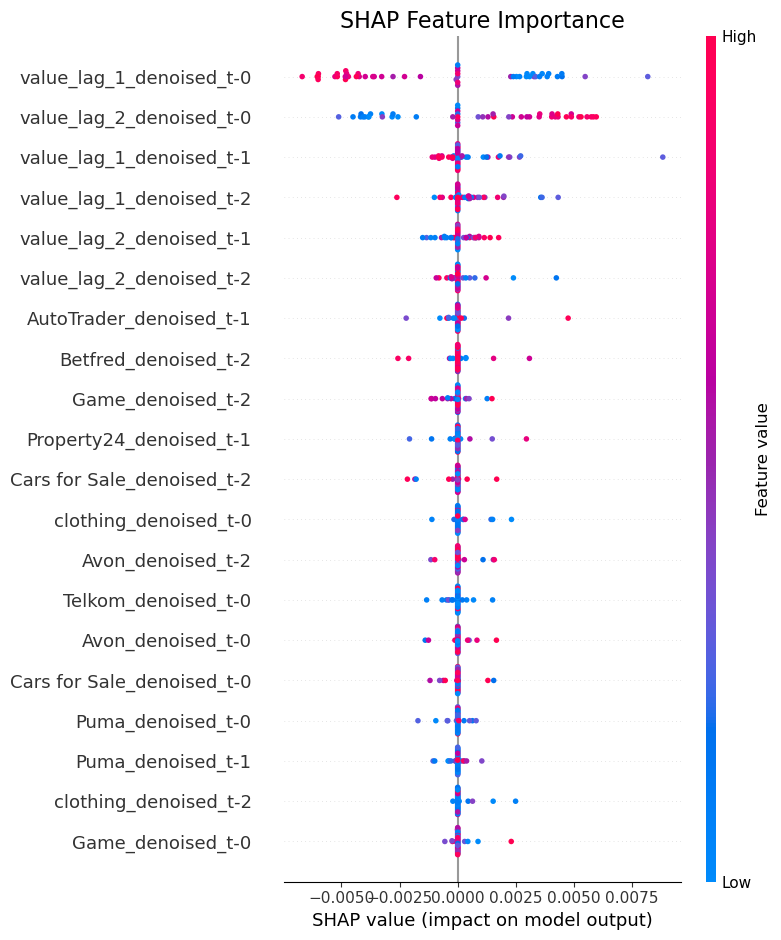

SHAP values shape: (50, 42)
Features shape: (50, 42)


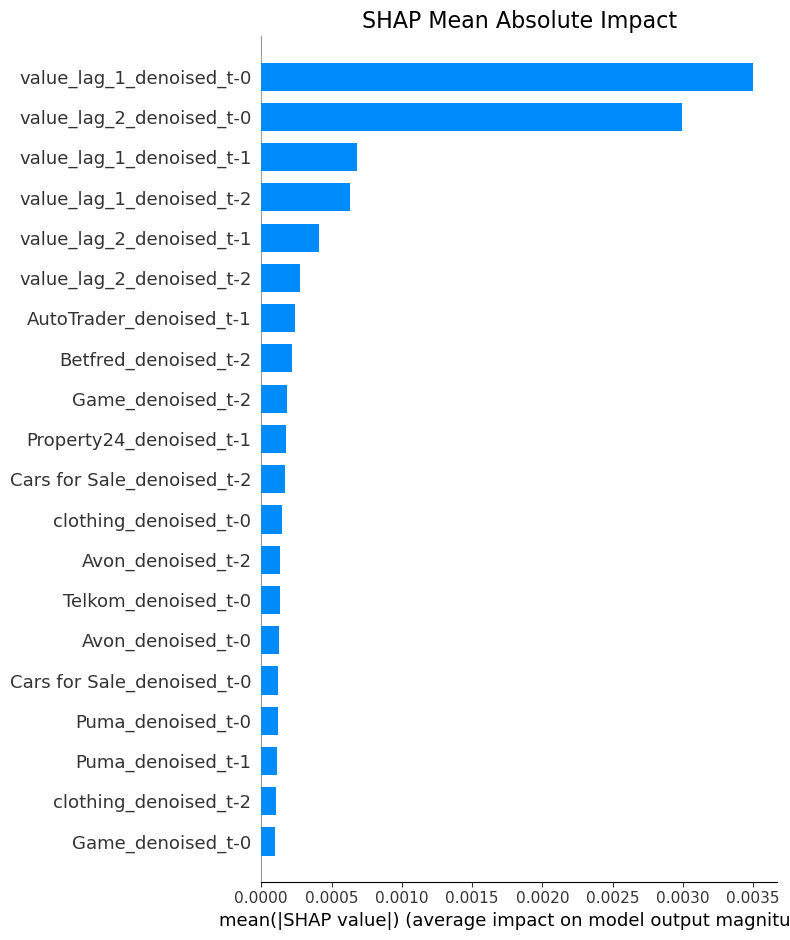

In [370]:
# =========================================
# Fixed Bi-GRU Explainability Script
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import shap
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Configuration
# ---------------------------
class XAIConfig:
    TIMESTEPS = 4  # Make sure this matches your model's timesteps
    N_SAMPLES = 50  # Reduced for stability
    BACKGROUND_SIZE = 20
    RANDOM_STATE = 42

config = XAIConfig()

# ---------------------------
# Debugging Data Shapes
# ---------------------------
def debug_data_shapes(X_val, y_val, model):
    """Debug function to understand data shapes"""
    print("\n=== DATA SHAPE DEBUGGING ===")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    
    # Check model input shape
    model_input_shape = model.input_shape
    print(f"Model input shape: {model_input_shape}")
    
    # Expected shape based on model
    expected_timesteps = model_input_shape[1]
    expected_features = model_input_shape[2]
    print(f"Expected timesteps: {expected_timesteps}")
    print(f"Expected features: {expected_features}")
    
    return expected_timesteps, expected_features

# ---------------------------
# Fixed Data Preparation
# ---------------------------
def prepare_timeseries_data(X_val, y_val, timesteps, feature_names=None):
    """
    Fixed data preparation with proper dimension handling
    """
    print(f"Original X_val shape: {X_val.shape}")
    print(f"Original y_val shape: {y_val.shape}")
    
    # Ensure float32
    X_val_np = X_val.astype(np.float32)
    y_val_np = y_val.astype(np.float32)
    
    # Handle different input formats
    if len(X_val_np.shape) == 2:
        # 2D input: (samples, features) - needs reshaping to 3D
        n_samples, n_features = X_val_np.shape
        
        # Calculate how many complete sequences we can create
        max_possible_sequences = n_samples - timesteps + 1
        if max_possible_sequences <= 0:
            raise ValueError(f"Not enough samples ({n_samples}) for timesteps ({timesteps})")
        
        # Create sequences
        X_val_3d = np.zeros((max_possible_sequences, timesteps, n_features))
        y_val_clean = np.zeros(max_possible_sequences)
        
        for i in range(max_possible_sequences):
            X_val_3d[i] = X_val_np[i:i+timesteps]
            y_val_clean[i] = y_val_np[i+timesteps-1]  # Target is the last point of sequence
        
        print(f"Created sequences: {X_val_3d.shape}")
        print(f"Target shape: {y_val_clean.shape}")
        
    elif len(X_val_np.shape) == 3:
        # Already 3D input: (samples, timesteps, features)
        X_val_3d = X_val_np
        y_val_clean = y_val_np.ravel() if len(y_val_np.shape) > 1 else y_val_np
        
    else:
        raise ValueError(f"Unsupported X_val shape: {X_val_np.shape}")
    
    # Flatten for SHAP (only for samples that work with timesteps)
    X_val_flat = X_val_3d.reshape(X_val_3d.shape[0], -1)
    
    # Create proper feature names
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(X_val_3d.shape[2])]
    
    timeseries_feature_names = [
        f"{col}_t-{t}" for t in range(timesteps-1, -1, -1) for col in feature_names
    ]
    
    print(f"Final X_val_3d shape: {X_val_3d.shape}")
    print(f"Final X_val_flat shape: {X_val_flat.shape}")
    print(f"Final y_val shape: {y_val_clean.shape}")
    print(f"Number of feature names: {len(timeseries_feature_names)}")
    
    return X_val_3d, X_val_flat, y_val_clean, timeseries_feature_names

# ---------------------------
# Fixed Model Predict Function
# ---------------------------
def create_predict_function(model, timesteps, n_features):
    """
    Fixed prediction function with proper dimension handling
    """
    def model_predict(X_input):
        try:
            # Handle single instance prediction
            if len(X_input.shape) == 1:
                X_input = X_input.reshape(1, -1)
            
            # Reshape to 3D: (samples, timesteps, features)
            n_samples = X_input.shape[0]
            X_input_3d = X_input.reshape(n_samples, timesteps, n_features)
            
            # Ensure the shape matches model expectations
            if X_input_3d.shape[1:] != model.input_shape[1:]:
                raise ValueError(f"Shape mismatch: {X_input_3d.shape[1:]} vs {model.input_shape[1:]}")
            
            predictions = model.predict(X_input_3d, verbose=0)
            return predictions.ravel()
        
        except Exception as e:
            print(f"Prediction error: {e}")
            print(f"Input shape: {X_input.shape}")
            print(f"Expected reshape: ({X_input.shape[0]}, {timesteps}, {n_features})")
            raise
    
    return model_predict

# ---------------------------
# Fixed SHAP Analysis
# ---------------------------
def shap_analysis(model, X_val_flat, X_val_3d, feature_names, config):
    """
    Fixed SHAP analysis with proper dimension handling
    """
    n_samples, timesteps, n_features = X_val_3d.shape
    
    print(f"\n=== SHAP ANALYSIS SETUP ===")
    print(f"X_val_3d shape: {X_val_3d.shape}")
    print(f"X_val_flat shape: {X_val_flat.shape}")
    print(f"Model input shape: {model.input_shape}")
    
    # Verify dimensions match
    if (timesteps, n_features) != model.input_shape[1:]:
        print(f"Warning: Data shape {timesteps, n_features} doesn't match model {model.input_shape[1:]}")
        # Adjust if possible
        if model.input_shape[1] is not None:
            timesteps = model.input_shape[1]
        if model.input_shape[2] is not None:
            n_features = model.input_shape[2]
    
    model_predict = create_predict_function(model, timesteps, n_features)
    
    # Smart background selection
    background_size = min(config.BACKGROUND_SIZE, len(X_val_flat))
    background_indices = np.random.choice(len(X_val_flat), background_size, replace=False)
    background = X_val_flat[background_indices]
    
    print(f"Background shape: {background.shape}")
    
    # 1. Kernel SHAP (most reliable)
    print("\nComputing Kernel SHAP...")
    try:
        explainer_kernel = shap.KernelExplainer(model_predict, background)
        
        # Use smaller sample size for stability
        sample_size = min(config.N_SAMPLES, len(X_val_flat))
        shap_values_kernel = explainer_kernel.shap_values(
            X_val_flat[:sample_size], 
            nsamples=50,  # Reduced for speed
            silent=True
        )
        
        print(f"Kernel SHAP values shape: {np.array(shap_values_kernel).shape}")
        
    except Exception as e:
        print(f"Kernel SHAP failed: {e}")
        shap_values_kernel = None
        explainer_kernel = None
    
    # 2. Gradient SHAP (only if model supports it and dimensions match)
    shap_values_gradient = None
    explainer_gradient = None
    
    try:
        print("\nAttempting Gradient SHAP...")
        # Verify we can use GradientExplainer
        if len(X_val_3d) >= config.BACKGROUND_SIZE:
            background_3d = X_val_3d[background_indices]
            
            # Ensure background matches model input shape
            if background_3d.shape[1:] == model.input_shape[1:]:
                explainer_gradient = shap.GradientExplainer(model, background_3d)
                
                sample_size = min(config.N_SAMPLES, len(X_val_3d))
                test_data = X_val_3d[:sample_size]
                
                shap_values_gradient = explainer_gradient.shap_values(test_data)
                
                # Handle multiple outputs
                if isinstance(shap_values_gradient, list):
                    shap_values_gradient = shap_values_gradient[0]
                
                print(f"Gradient SHAP values shape: {np.array(shap_values_gradient).shape}")
            else:
                print("Background shape doesn't match model input shape")
                
    except Exception as e:
        print(f"Gradient SHAP failed: {e}")
    
    return {
        'kernel': (shap_values_kernel, explainer_kernel) if shap_values_kernel is not None else None,
        'gradient': (shap_values_gradient, explainer_gradient) if shap_values_gradient is not None else None,
        'feature_names': feature_names
    }

# ---------------------------
# Safe Visualization
# ---------------------------
def safe_shap_plot(shap_values, features, feature_names, plot_type="summary"):
    """
    Safe SHAP plotting with error handling
    """
    try:
        if shap_values is None or len(shap_values) == 0:
            print("No SHAP values to plot")
            return
        
        shap_array = np.array(shap_values)
        features_array = np.array(features)
        
        print(f"SHAP values shape: {shap_array.shape}")
        print(f"Features shape: {features_array.shape}")
        
        if shap_array.shape[0] != features_array.shape[0]:
            print("Shape mismatch between SHAP values and features")
            return
        
        if plot_type == "summary":
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_array, features_array, 
                            feature_names=feature_names, show=False)
            plt.title("SHAP Feature Importance", fontsize=16)
            plt.tight_layout()
            plt.show()
            
        elif plot_type == "bar":
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_array, features_array, 
                            feature_names=feature_names, plot_type="bar", show=False)
            plt.title("SHAP Mean Absolute Impact", fontsize=16)
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Plotting error: {e}")

# ---------------------------
# Main Analysis Function (Fixed)
# ---------------------------
def comprehensive_xai_analysis(model, X_val, y_val, feature_names=None, config=config):
    """
    Fixed main analysis function
    """
    print("Starting Comprehensive XAI Analysis...")
    
    # First debug the shapes
    expected_timesteps, expected_features = debug_data_shapes(X_val, y_val, model)
    config.TIMESTEPS = expected_timesteps  # Use model's expected timesteps
    
    # Prepare data with correct dimensions
    X_val_3d, X_val_flat, y_val_clean, timeseries_feature_names = prepare_timeseries_data(
        X_val, y_val, config.TIMESTEPS, feature_names
    )
    
    # SHAP Analysis
    shap_results = shap_analysis(model, X_val_flat, X_val_3d, timeseries_feature_names, config)
    
    # Plot results safely
    if shap_results['kernel']:
        shap_values, explainer = shap_results['kernel']
        sample_size = min(config.N_SAMPLES, len(X_val_flat))
        
        print(f"\nPlotting Kernel SHAP results...")
        safe_shap_plot(shap_values, X_val_flat[:sample_size], 
                      timeseries_feature_names, "summary")
        safe_shap_plot(shap_values, X_val_flat[:sample_size], 
                      timeseries_feature_names, "bar")
    
    # Alternative: Individual Feature Importance if SHAP fails
    if shap_results['kernel'] is None:
        print("\nSHAP failed, using alternative feature importance...")
        alternative_feature_importance(model, X_val_3d, y_val_clean, timeseries_feature_names)
    
    return {
        'shap_results': shap_results,
        'feature_names': timeseries_feature_names,
        'data_shapes': {
            'X_val_3d': X_val_3d.shape,
            'X_val_flat': X_val_flat.shape,
            'y_val': y_val_clean.shape
        }
    }

def alternative_feature_importance(model, X_val_3d, y_val, feature_names):
    """
    Alternative method if SHAP fails
    """
    # Simple permutation importance
    original_score = model.evaluate(X_val_3d, y_val, verbose=0)[0]
    
    feature_importance = []
    n_features = X_val_3d.shape[2]
    
    for i in range(n_features):
        X_perturbed = X_val_3d.copy()
        # Shuffle the i-th feature across all timesteps
        for t in range(X_val_3d.shape[1]):
            X_perturbed[:, t, i] = np.random.permutation(X_perturbed[:, t, i])
        
        perturbed_score = model.evaluate(X_perturbed, y_val, verbose=0)[0]
        importance = perturbed_score - original_score
        feature_importance.append((feature_names[i], importance))
    
    # Sort by importance
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    # Plot
    features, importances = zip(*feature_importance[:15])  # Top 15
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(features)), importances)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance (Increase in Loss)')
    plt.title('Feature Importance (Permutation Method)')
    plt.tight_layout()
    plt.show()

# ---------------------------
# Usage Example
# ---------------------------
# How to use it with your data:

# First, ensure your validation data is properly prepared
def prepare_validation_data(model, train, val, test, target_col, feature_cols, timesteps):
    """
    Prepare validation data that matches model expectations
    """
    # Use validation set for XAI
    X_val = val[feature_cols].values
    y_val = val[target_col].values
    
    print(f"Raw X_val shape: {X_val.shape}")
    print(f"Raw y_val shape: {y_val.shape}")
    
    return X_val, y_val
feature_cols = X_train_df.columns.tolist()

# Then run the analysis
X_val, y_val = prepare_validation_data(model, train, val, test, 'Value_denoised', feature_cols, timesteps=4)
results = comprehensive_xai_analysis(model, X_val, y_val, feature_names=feature_cols)

In [ ]:
# ---------------------------
# Residual Analysis
# ---------------------------

def enhanced_residual_analysis(model, X_val_flat, y_val_np, timesteps, n_features, feature_names=None):
    """
    Comprehensive residual analysis with statistical tests and insights
    """
    print("=== ENHANCED RESIDUAL ANALYSIS ===")
    
    # Enhanced prediction function with error handling
    def model_predict(X_input):
        try:
            X_input_3d = X_input.reshape(X_input.shape[0], timesteps, n_features)
            return model.predict(X_input_3d, verbose=0).ravel()
        except Exception as e:
            print(f"Prediction error: {e}")
            return np.zeros(X_input.shape[0])
    
    # Generate predictions
    y_val_pred = model_predict(X_val_flat)
    
    # Calculate residuals and metrics
    residuals = y_val_np - y_val_pred
    mse = np.mean(residuals**2)
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(mse)
    
    print(f"Residual Statistics:")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    print(f"Mean Residual: {np.mean(residuals):.4f}")
    print(f"Std Residual: {np.std(residuals):.4f}")
    
    # Create subplots for comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Predictions vs Actual
    plt.subplot(3, 3, 1)
    plt.plot(y_val_np, label='Actual', alpha=0.7, linewidth=1)
    plt.plot(y_val_pred, label='Predicted', alpha=0.7, linewidth=1)
    plt.legend()
    plt.title('Bi-GRU: Predictions vs Actual\n(RMSE: {:.4f})'.format(rmse))
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    
    # 2. Residuals over Time
    plt.subplot(3, 3, 2)
    plt.plot(residuals, color='red', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.fill_between(range(len(residuals)), residuals, alpha=0.3, color='red')
    plt.title('Residuals over Time\n(Mean: {:.4f})'.format(np.mean(residuals)))
    plt.xlabel('Time Step')
    plt.ylabel('Residual')
    plt.grid(True, alpha=0.3)
    
    # 3. Residual Distribution
    plt.subplot(3, 3, 3)
    n, bins, patches = plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
    plt.axvline(x=np.mean(residuals), color='green', linestyle='--', linewidth=2, label='Mean')
    plt.title('Residual Distribution\n(Skew: {:.4f})'.format(pd.Series(residuals).skew()))
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Q-Q Plot for normality check
    plt.subplot(3, 3, 4)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot: Normality Check')
    plt.grid(True, alpha=0.3)
    
    # 5. Residuals vs Predicted
    plt.subplot(3, 3, 5)
    plt.scatter(y_val_pred, residuals, alpha=0.5, color='blue')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted\n(Homoscedasticity Check)')
    plt.grid(True, alpha=0.3)
    
    # 6. Autocorrelation of Residuals
    plt.subplot(3, 3, 6)
    from statsmodels.tsa.stattools import acf
    lag_acf = acf(residuals, nlags=20)
    plt.stem(range(len(lag_acf)), lag_acf, basefmt=" ")
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=1.96/np.sqrt(len(residuals)), color='red', linestyle='--', alpha=0.5, label='95% CI')
    plt.axhline(y=-1.96/np.sqrt(len(residuals)), color='red', linestyle='--', alpha=0.5)
    plt.title('Autocorrelation of Residuals')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Cumulative Residuals
    plt.subplot(3, 3, 7)
    cumulative_residuals = np.cumsum(residuals)
    plt.plot(cumulative_residuals, color='purple')
    plt.title('Cumulative Residuals\n(Trend Analysis)')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Residual')
    plt.grid(True, alpha=0.3)
    
    # 8. Residuals Density Plot
    plt.subplot(3, 3, 8)
    import seaborn as sns
    sns.kdeplot(residuals, fill=True, color='orange', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    plt.title('Residuals Density Plot')
    plt.xlabel('Residual')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    
    # 9. Residuals Box Plot
    plt.subplot(3, 3, 9)
    plt.boxplot(residuals, vert=True, patch_artist=True)
    plt.title('Residuals Box Plot\n(Outlier Detection)')
    plt.ylabel('Residual')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("\n=== STATISTICAL TESTS ===")
    
    # Normality test
    from scipy.stats import shapiro, normaltest
    try:
        shapiro_stat, shapiro_p = shapiro(residuals)
        print(f"Shapiro-Wilk Normality Test: p-value = {shapiro_p:.6f}")
        if shapiro_p > 0.05:
            print("  → Residuals appear normal (fail to reject H0)")
        else:
            print("  → Residuals NOT normal (reject H0)")
    except:
        print("Shapiro-Wilk test failed (possibly too many samples)")
    
    # Autocorrelation test
    from statsmodels.stats.diagnostic import acorr_ljungbox
    try:
        lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
        p_value = lb_test['lb_pvalue'].iloc[-1]
        print(f"Ljung-Box Autocorrelation Test: p-value = {p_value:.6f}")
        if p_value > 0.05:
            print("  → No significant autocorrelation (fail to reject H0)")
        else:
            print("  → Significant autocorrelation present (reject H0)")
    except:
        print("Ljung-Box test failed")
    
    # Heteroscedasticity test
    from statsmodels.stats.diagnostic import het_arch
    try:
        arch_test = het_arch(residuals)
        arch_p = arch_test[1]
        print(f"ARCH Heteroscedasticity Test: p-value = {arch_p:.6f}")
        if arch_p > 0.05:
            print("  → Constant variance (homoscedastic)")
        else:
            print("  → Non-constant variance (heteroscedastic)")
    except:
        print("ARCH test failed")
    
    return {
        'predictions': y_val_pred,
        'residuals': residuals,
        'metrics': {
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'mean_residual': np.mean(residuals),
            'std_residual': np.std(residuals),
            'skewness': pd.Series(residuals).skew(),
            'kurtosis': pd.Series(residuals).kurtosis()
        },
        'tests': {
            'normality_p': shapiro_p if 'shapiro_p' in locals() else None,
            'autocorrelation_p': p_value if 'p_value' in locals() else None,
            'heteroscedasticity_p': arch_p if 'arch_p' in locals() else None
        }
    }

# ---------------------------
# Residual Analysis by Feature Importance
# ---------------------------

def residual_analysis_by_features(model, X_val_flat, y_val_np, residuals, feature_names, timesteps, n_features, top_n=10):
    """
    Analyze residuals based on feature importance
    """
    print("\n=== RESIDUAL ANALYSIS BY FEATURES ===")
    
    # Calculate feature importance (simple method)
    feature_importance = np.abs(X_val_flat).mean(axis=0)
    important_features_idx = np.argsort(feature_importance)[-top_n:][::-1]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Residuals vs Top Features
    for i, idx in enumerate(important_features_idx[:4]):  # Top 4 features
        ax = axes[i//2, i%2]
        ax.scatter(X_val_flat[:, idx], residuals, alpha=0.5)
        ax.set_xlabel(f'{feature_names[idx]}')
        ax.set_ylabel('Residuals')
        ax.set_title(f'Residuals vs {feature_names[idx]}')
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Residual patterns analysis
    print("\nTop features correlation with residuals:")
    for idx in important_features_idx[:5]:
        corr = np.corrcoef(X_val_flat[:, idx], residuals)[0, 1]
        print(f"  {feature_names[idx]}: {corr:.4f}")

# ---------------------------
# Time-based Residual Analysis
# ---------------------------

def temporal_residual_analysis(residuals, timestamps=None):
    """
    Analyze temporal patterns in residuals
    """
    print("\n=== TEMPORAL RESIDUAL ANALYSIS ===")
    
    if timestamps is not None and len(timestamps) == len(residuals):
        residuals_series = pd.Series(residuals, index=timestamps)
        
        # Resample if datetime index
        if isinstance(timestamps, pd.DatetimeIndex):
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Daily patterns
            try:
                daily_avg = residuals_series.groupby(residuals_series.index.hour).mean()
                axes[0,0].plot(daily_avg.index, daily_avg.values)
                axes[0,0].set_title('Residuals by Hour of Day')
                axes[0,0].set_xlabel('Hour')
                axes[0,0].grid(True, alpha=0.3)
            except:
                pass
            
            # Weekly patterns
            try:
                weekly_avg = residuals_series.groupby(residuals_series.index.dayofweek).mean()
                axes[0,1].plot(weekly_avg.index, weekly_avg.values)
                axes[0,1].set_title('Residuals by Day of Week')
                axes[0,1].set_xlabel('Day of Week (0=Monday)')
                axes[0,1].grid(True, alpha=0.3)
            except:
                pass
            
            # Monthly patterns
            try:
                monthly_avg = residuals_series.groupby(residuals_series.index.month).mean()
                axes[1,0].plot(monthly_avg.index, monthly_avg.values)
                axes[1,0].set_title('Residuals by Month')
                axes[1,0].set_xlabel('Month')
                axes[1,0].grid(True, alpha=0.3)
            except:
                pass
            
            # Rolling mean
            try:
                rolling_mean = residuals_series.rolling(window=7).mean()
                axes[1,1].plot(rolling_mean.index, rolling_mean.values)
                axes[1,1].set_title('7-Day Rolling Mean of Residuals')
                axes[1,1].grid(True, alpha=0.3)
            except:
                pass
            
            plt.tight_layout()
            plt.show()

# ---------------------------
# Complete Residual Analysis Pipeline
# ---------------------------

def complete_residual_analysis_pipeline(model, X_val_flat, y_val_np, feature_names, timesteps, n_features, timestamps=None):
    """
    Complete pipeline for residual analysis
    """
    # Main residual analysis
    results = enhanced_residual_analysis(model, X_val_flat, y_val_np, timesteps, n_features, feature_names)
    
    # Feature-based analysis
    #residual_analysis_by_features(model, X_val_flat, y_val_np, results['residuals'], 
                               # feature_names, timesteps, n_features)
    
    # Temporal analysis
    temporal_residual_analysis(results['residuals'], timestamps)
    
    # Print summary insights
    print("\n=== RESIDUAL ANALYSIS INSIGHTS ===")
    metrics = results['metrics']
    
    if abs(metrics['mean_residual']) > 0.1 * metrics['std_residual']:
        print("⚠️  Bias detected: Mean residual is significantly different from zero")
    else:
        print("✓ No significant bias detected")
    
    if metrics['skewness'] > 1 or metrics['skewness'] < -1:
        print("⚠️  Skewed residuals: Distribution is not symmetric")
    else:
        print("✓ Residuals are reasonably symmetric")
    
    if results['tests'].get('autocorrelation_p', 1) < 0.05:
        print("⚠️  Autocorrelation present: Model may be missing temporal patterns")
    else:
        print("✓ No significant autocorrelation detected")
    
    return results



=== ENHANCED RESIDUAL ANALYSIS ===
Residual Statistics:
MSE: 18970109952.0000, MAE: 132291.6094, RMSE: 137732.0156
Mean Residual: 132291.6094
Std Residual: 38328.0781


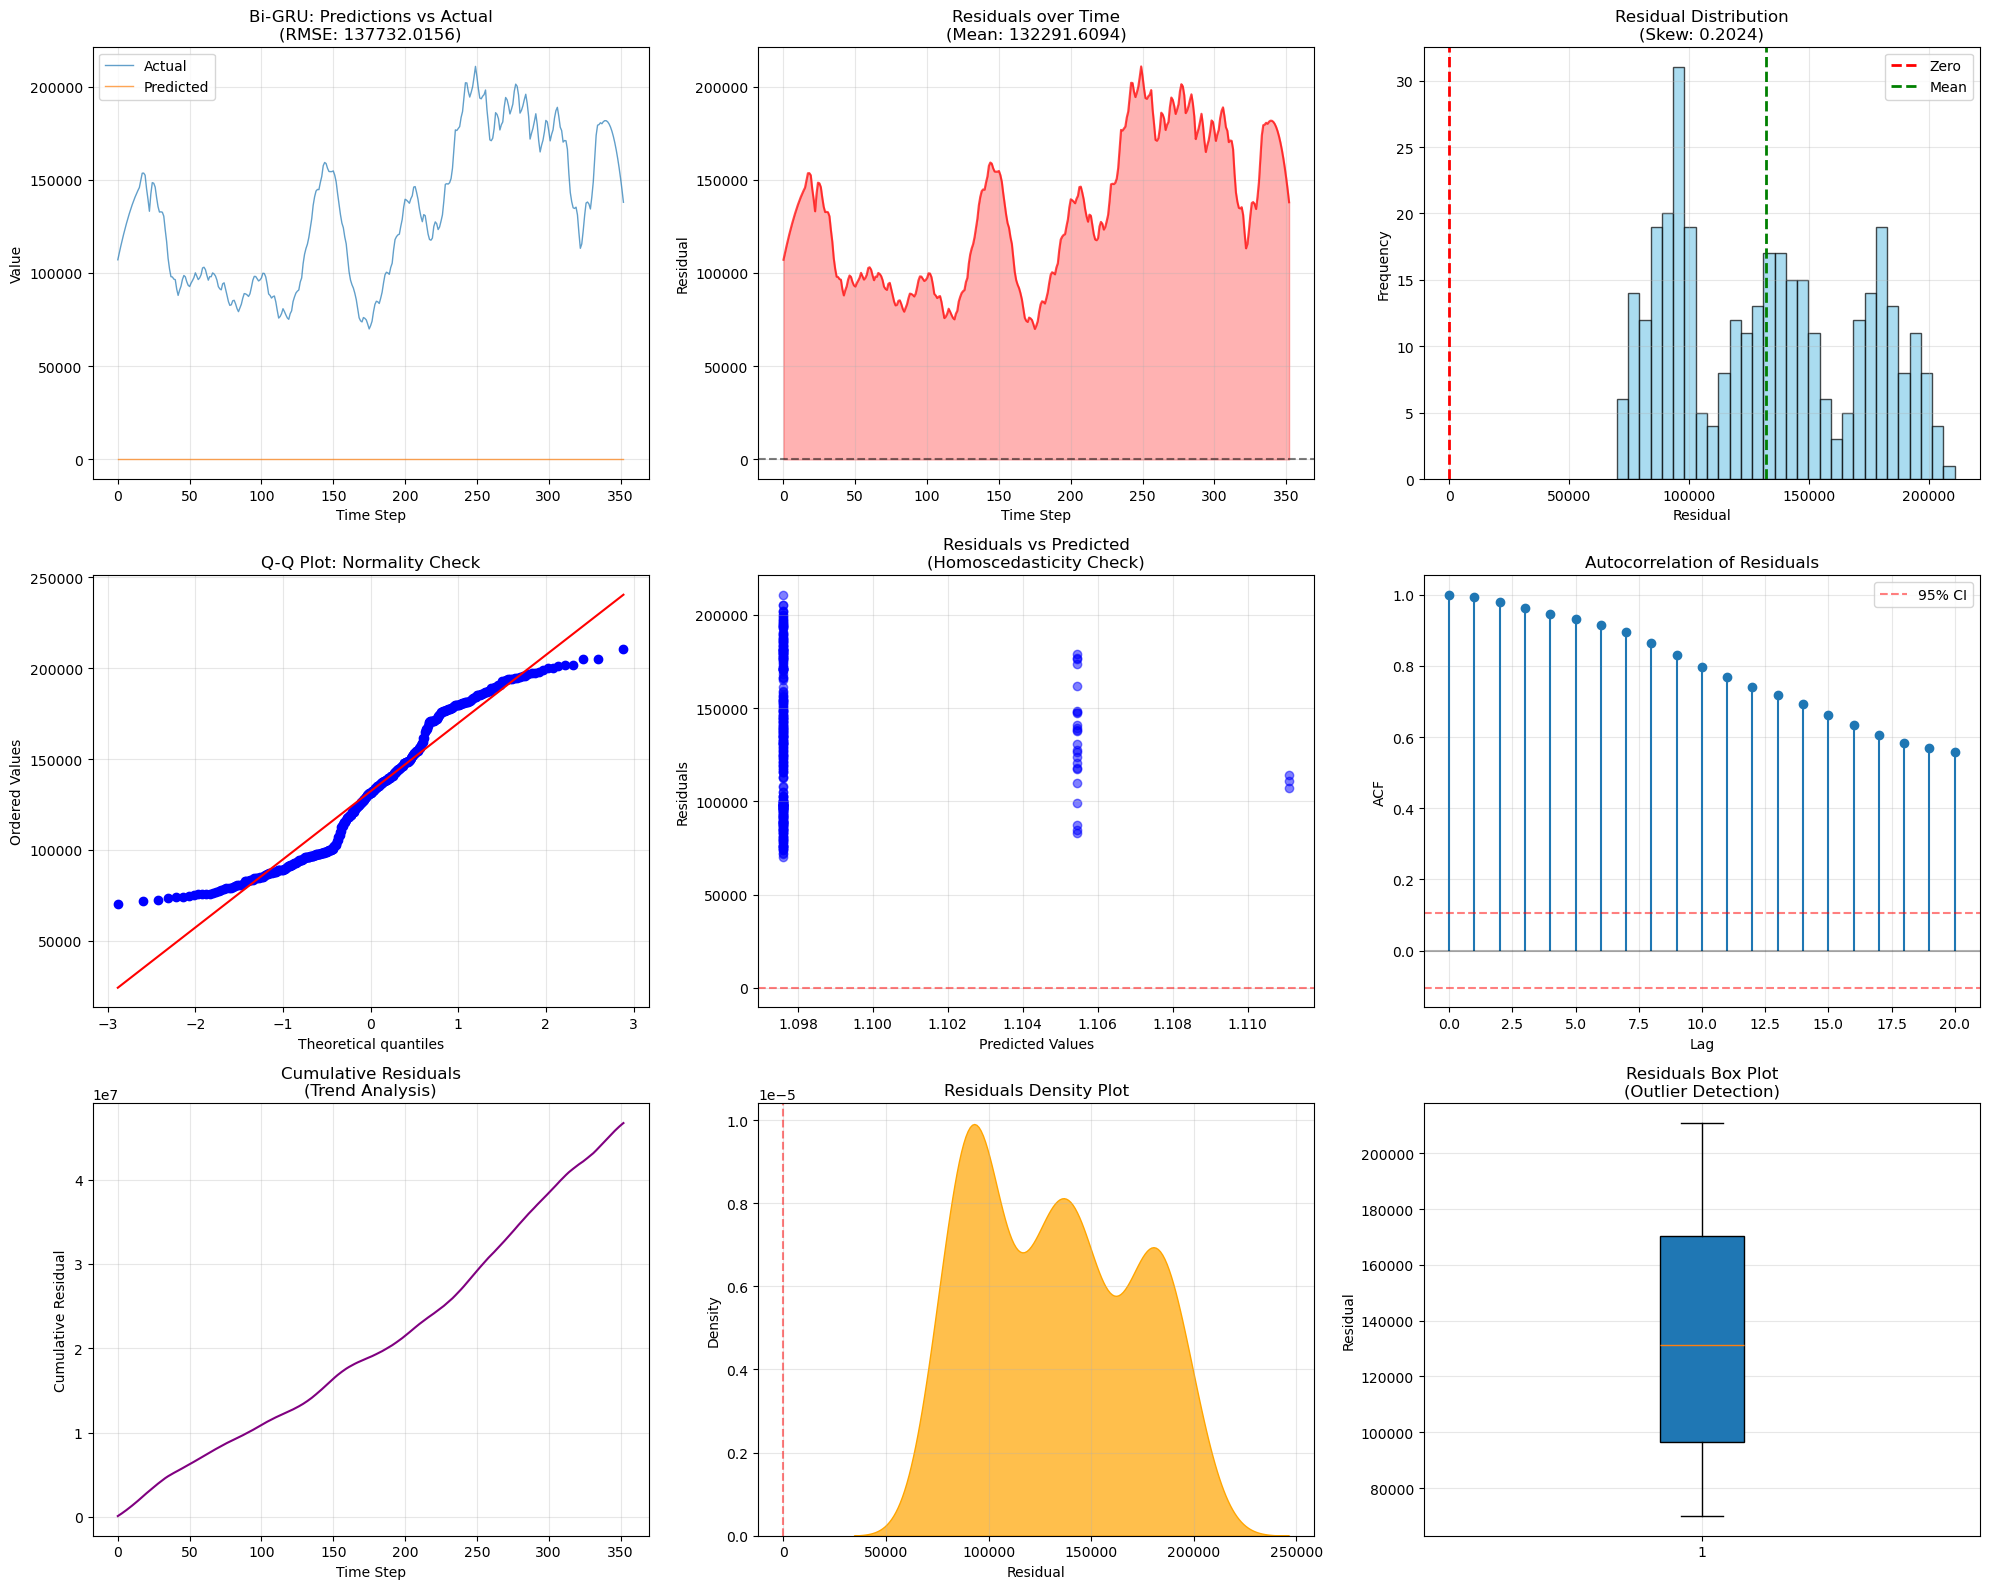


=== STATISTICAL TESTS ===
Shapiro-Wilk Normality Test: p-value = 0.000000
  → Residuals NOT normal (reject H0)
Ljung-Box Autocorrelation Test: p-value = 0.000000
  → Significant autocorrelation present (reject H0)
ARCH Heteroscedasticity Test: p-value = 0.000000
  → Non-constant variance (heteroscedastic)

=== TEMPORAL RESIDUAL ANALYSIS ===

=== RESIDUAL ANALYSIS INSIGHTS ===
⚠️  Bias detected: Mean residual is significantly different from zero
✓ Residuals are reasonably symmetric
⚠️  Autocorrelation present: Model may be missing temporal patterns


In [373]:
# Run the complete analysis
results = complete_residual_analysis_pipeline(
    model=model,
    X_val_flat=X_val_flat,
    y_val_np=y_val_np,
    feature_names=feature_cols,
    timesteps=timesteps,
    n_features=n_features
)